This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections:

Forecast for a single time step:
A single feature.
All features.
Forecast multiple steps:
Single-shot: Make the predictions all at once.
Autoregressive: Make one prediction at a time and feed the output back to the model.

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

The weather dataset
This tutorial uses a weather time series dataset recorded by the Max Planck Institute for Biogeochemistry.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True,
    cache_dir='.',
    cache_subdir=os.getcwd())
csv_path, _ = os.path.splitext(zip_path)

In [3]:
os.path.splitext(zip_path)

('d:\\a27_YEARS_OLD\\deep_learning\\timeseries\\jena_climate_2009_2016_extracted',
 '')

In [4]:
zip_path

'd:\\a27_YEARS_OLD\\deep_learning\\timeseries\\jena_climate_2009_2016_extracted'

This tutorial will just deal with hourly predictions, so start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [5]:
df = pd.read_csv(csv_path + '/jena_climate_2009_2016.csv')

In [6]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [7]:
df.shape

(420551, 15)

In [8]:
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

In [9]:
df.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
35,01.01.2009 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0
41,01.01.2009 07:00:00,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.8
47,01.01.2009 08:00:00,999.17,-8.10,265.12,-9.05,92.8,3.31,3.07,0.24,1.92,3.08,1311.65,0.72,1.25,213.9
53,01.01.2009 09:00:00,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,0.34,0.63,202.2
59,01.01.2009 10:00:00,1000.27,-7.04,266.10,-8.17,91.6,3.60,3.30,0.30,2.05,3.29,1307.76,1.45,3.00,292.6


In [10]:
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [11]:
date_time[:10]

5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
35   2009-01-01 06:00:00
41   2009-01-01 07:00:00
47   2009-01-01 08:00:00
53   2009-01-01 09:00:00
59   2009-01-01 10:00:00
Name: Date Time, dtype: datetime64[ns]

In [12]:
df.head(10)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
35,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0
41,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.8
47,999.17,-8.10,265.12,-9.05,92.8,3.31,3.07,0.24,1.92,3.08,1311.65,0.72,1.25,213.9
53,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,0.34,0.63,202.2
59,1000.27,-7.04,266.10,-8.17,91.6,3.60,3.30,0.30,2.05,3.29,1307.76,1.45,3.00,292.6


Here is the evolution of a few features over time:

In [13]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']

In [14]:
plot_features = df[plot_cols]

In [15]:
plot_features

,T (degC),p (mbar),rho (g/m**3)
5,-8.05,996.50,1307.86
11,-8.88,996.62,1312.25
17,-8.81,996.84,1312.18
23,-9.05,996.99,1313.61
29,-9.63,997.46,1317.19
...,...,...,...
420521,-0.98,1002.18,1280.70
420527,-1.40,1001.40,1281.87
420533,-2.75,1001.19,1288.02
420539,-2.89,1000.65,1288.03


In [16]:
plot_features.index = date_time

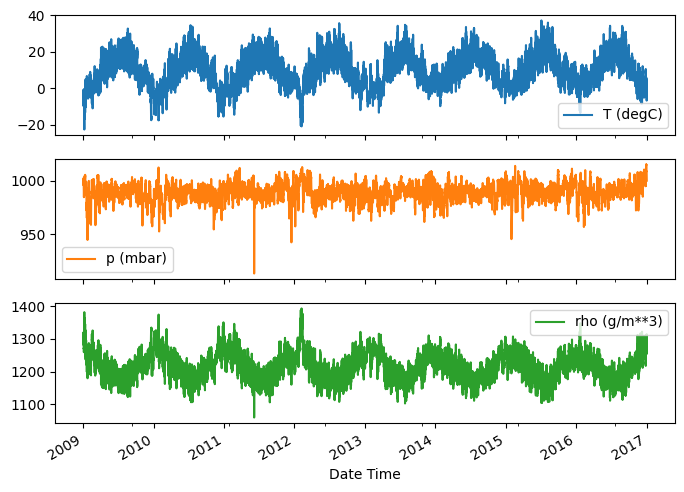

In [17]:
_ = plot_features.plot(subplots=True)

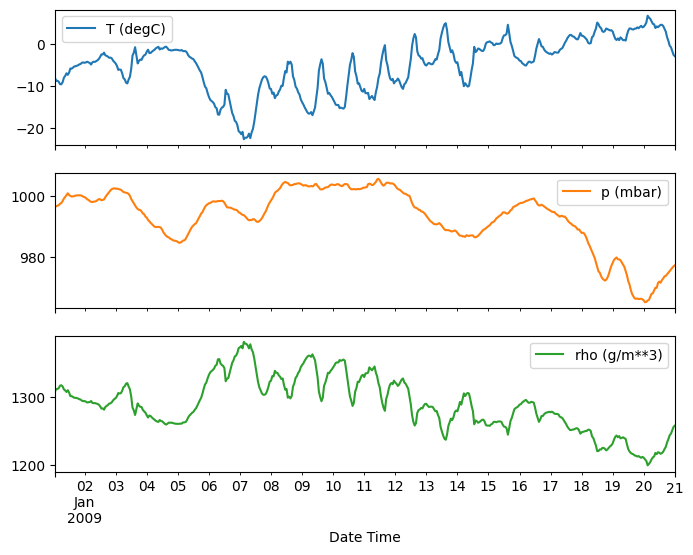

In [18]:
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

Inspect and cleanup
Next, look at the statistics of the dataset:

In [19]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


Wind velocity
One thing that should stand out is the min value of the wind velocity (wv (m/s)) and the maximum value (max. wv (m/s)) columns. This -9999 is likely erroneous.

There's a separate wind direction column, so the velocity should be greater than zero (>=0). Replace it with zero

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0 # get a list of true and false values
wv[bad_wv] = 0.0 # index corresponding true wv set to zero

In [21]:
wv[:5]

5     0.21
11    0.25
17    0.18
23    0.10
29    0.40
Name: wv (m/s), dtype: float64

In [22]:
bad_wv[:5]

5     False
11    False
17    False
23    False
29    False
Name: wv (m/s), dtype: bool

In [23]:
wv[bad_wv]

343583    0.0
343589    0.0
343595    0.0
Name: wv (m/s), dtype: float64

In [24]:
max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

In [25]:
# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()


np.float64(0.0)

In [26]:
df['max. wv (m/s)'].min()

np.float64(0.0)

In [7]:
a = [0,1,2,3,4,5,6,7,8,9]

In [4]:
for i in range(len(a)):
    print(a[0:i+1])

[0]
[0, 1]
[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [8]:
for i in range(len(a)):
    print((len(a)-(i+1))*" ",a[0:i+1])

          [0]
         [0, 1]
        [0, 1, 2]
       [0, 1, 2, 3]
      [0, 1, 2, 3, 4]
     [0, 1, 2, 3, 4, 5]
    [0, 1, 2, 3, 4, 5, 6]
   [0, 1, 2, 3, 4, 5, 6, 7]
  [0, 1, 2, 3, 4, 5, 6, 7, 8]
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [7]:
for i in range(len(a)):
    print((len(a)-(i+1))*3*" ",a[0:i+1])

                            [0]
                         [0, 1]
                      [0, 1, 2]
                   [0, 1, 2, 3]
                [0, 1, 2, 3, 4]
             [0, 1, 2, 3, 4, 5]
          [0, 1, 2, 3, 4, 5, 6]
       [0, 1, 2, 3, 4, 5, 6, 7]
    [0, 1, 2, 3, 4, 5, 6, 7, 8]
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [3]:
b= "2[a]3[bc]" # output = "aabcbc"

In [1]:
s=str()

In [ ]:
for i in range(len(b)):
    if b[i] == "[":
        c = str()
        for j in range(i+1,len(b)):
            if b[j] == "]":
                break
            else:
                c += b[j]
        s += int(b[i-1])*c
    

In [5]:
s

'aabcbcbc'

Feature engineering


Before diving in to build a model, it's important to understand your data and be sure that you're passing the model appropriately formatted data

Wind
The last column of the data, wd (deg)—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

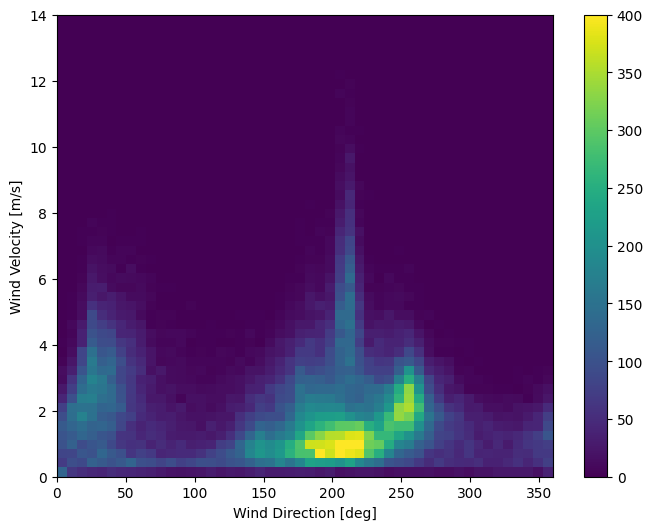

In [27]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector:

In [28]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

In [29]:
# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

In [30]:
# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

In [31]:
# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

he distribution of wind vectors is much simpler for the model to correctly interpret:

Get Current Axis: ax = plt.gca()
plt.gca() returns the current axis instance (or creates one if there isn't one already).
The axis instance is stored in the variable ax.
Set Tight Layout: ax.axis('tight')
ax.axis('tight') sets the axis limits to fit the data tightly, removing any extra whitespace.

(np.float64(-11.305513973134667),
 np.float64(8.24469928549079),
 np.float64(-8.27438540335515),
 np.float64(7.7338312955467785))

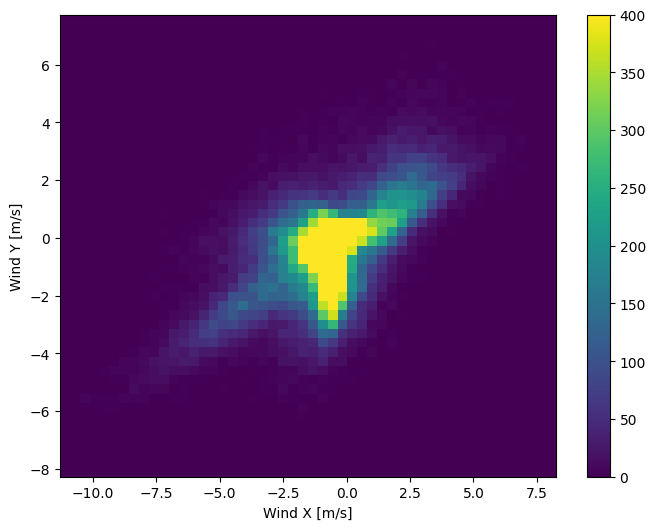

In [32]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Time
Similarly, the Date Time column is very useful, but not in this string form. Start by converting it to seconds

In [33]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [34]:
date_time[:10]

5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
35   2009-01-01 06:00:00
41   2009-01-01 07:00:00
47   2009-01-01 08:00:00
53   2009-01-01 09:00:00
59   2009-01-01 10:00:00
Name: Date Time, dtype: datetime64[ns]

In [35]:
timestamp_s[:10] 

5     1.230772e+09
11    1.230775e+09
17    1.230779e+09
23    1.230782e+09
29    1.230786e+09
35    1.230790e+09
41    1.230793e+09
47    1.230797e+09
53    1.230800e+09
59    1.230804e+09
Name: Date Time, dtype: float64

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:


In [36]:
day = 24*60*60
year = (365.2425)*day

In [37]:
np.pi

3.141592653589793

In [38]:
(2 * np.pi / day) # 2pi/day = 360/24*60*60 =2*3.14/ 24*60*60    > radian per second

7.27220521664304e-05

In [39]:
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [40]:
df['Day sin'][:10]

5     0.258819
11    0.500000
17    0.707107
23    0.866025
29    0.965926
35    1.000000
41    0.965926
47    0.866025
53    0.707107
59    0.500000
Name: Day sin, dtype: float64

Text(0.5, 1.0, 'Time of day signal')

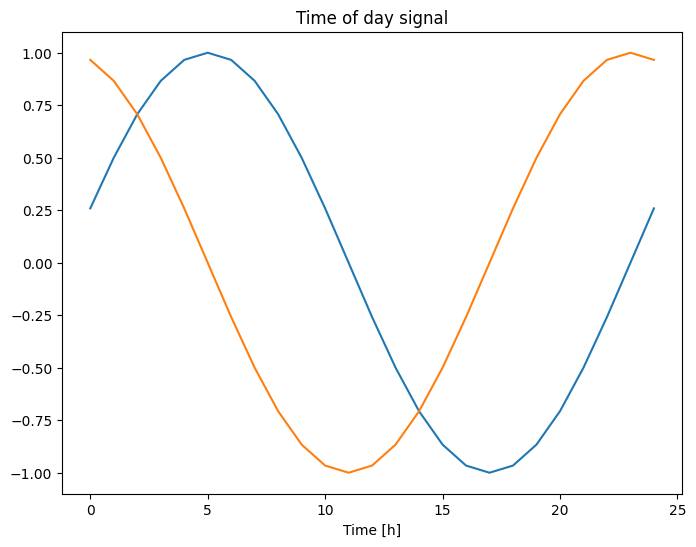

In [41]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

If you don't have that information, you can determine which frequencies are important by extracting features with Fast Fourier Transform. To check the assumptions, here is the tf.signal.rfft of the temperature over time. Note the obvious peaks at frequencies near 1/year and 1/day:

frequency = 1/time period . Here time periods are year and date 

so we get two frequency components 

find frequency components in a compound frequency wave using fourier transform

convert spatial domain to frequency domain

In [ ]:
fft = tf.signal.rfft(df['T (degC)']) # find frequency components from the spatial domain`of temperature`
no_freq_in_dataset = np.arange(0, len(fft))

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'


In [43]:
no_freq_in_dataset

array([    0,     1,     2, ..., 35043, 35044, 35045])

In [44]:
df['T (degC)'][:5]

5    -8.05
11   -8.88
17   -8.81
23   -9.05
29   -9.63
Name: T (degC), dtype: float64

In [45]:
fft

<tf.Tensor: shape=(35046,), dtype=complex64, numpy=
array([ 6.6239369e+05+0.0000000e+00j, -4.6668330e+03+3.7410137e+04j,
       -2.7058491e+03+1.2410740e+04j, ..., -2.9588785e+01+2.2237301e+01j,
        2.2038443e+01-3.7979412e+01j,  6.8314880e+01+2.2538704e+01j],
      dtype=complex64)>

In [46]:
len(fft)

35046

In [47]:
len(df['T (degC)'])

70091

Fast Fourier Transform (FFT): fft = tf.signal.rfft(df['T (degC)'])
Applies the real-valued Fast Fourier Transform (RFFT) to the temperature data (df['T (degC)']).
Returns the frequency domain representation of the data.
Frequency Indices: f_per_dataset = np.arange(0, len(fft))
Generates an array of frequency indices corresponding to the FFT output.
Indices range from 0 to the length of the FFT output.
Calculate Years per Dataset:
n_samples_h = len(df['T (degC)']): Gets the number of samples (data points) in the temperature dataset.
hours_per_year = 24*365.2524: Calculates the average number of hours in a year.
years_per_dataset = n_samples_h/hours_per_year: Calculates the number of

years represented by the dataset.
Convert Frequency Indices to Years: f_per_year = f_per_dataset/years_per_dataset
Scales the frequency indices (f_per_dataset) by the number of years in the dataset (years_per_dataset).
Results in frequency values in units of "per year".

In [ ]:
n_samples_h = len(df['T (degC)']) # number of hours in the dataset is the length of the dataset
hours_per_year = 24*365.2524
no_years_in_dataset = n_samples_h/(hours_per_year)

In [49]:
no_years_in_dataset

7.995726608047841

In [50]:
no_freq_in_dataset

array([    0,     1,     2, ..., 35043, 35044, 35045])

In [51]:
no_years_in_dataset

7.995726608047841

In [ ]:
no_of_freq_per_year = no_freq_in_dataset/no_years_in_dataset    

= (no_freq/dataset)/(no_years/dataset)

In [53]:
no_of_freq_per_year

array([0.00000000e+00, 1.25066807e-01, 2.50133615e-01, ...,
       4.38271613e+03, 4.38284120e+03, 4.38296627e+03])

In [54]:
len(no_of_freq_per_year)

35046

In [55]:
np.abs(fft)

array([6.6239369e+05, 3.7700102e+04, 1.2702287e+04, ..., 3.7013428e+01,
       4.3910461e+01, 7.1936890e+01], dtype=float32)

Convert Frequency Indices to Years: f_per_year = f_per_dataset/years_per_dataset
Scales the frequency indices (f_per_dataset) by the number of years in the dataset (years_per_dataset).
Results in frequency values in units of "per year".

Frequency Conversion: f_per_year = f_per_dataset/years_per_dataset
Converts frequency indices to units of "per year".
Plot Frequency Spectrum: plt.step(f_per_year, np.abs(fft))
Plots the absolute values of the FFT output (np.abs(fft)) against the frequency values (f_per_year).
Uses step plot to display the discrete frequency spectrum.


Sets the x-axis (frequency) to a logarithmic scale.
Y-Axis Limits: plt.ylim(0, 400000)
Sets the y-axis limits to [0, 400000].
X-Axis Limits: plt.xlim([0.1, max(plt.xlim())])
Sets the x-axis limits to [0.1, max(xlim)], focusing on frequencies > 0.1/year.
Custom X-Ticks: plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
Adds custom x-axis ticks at frequencies 1/year and 1/day.
X-Axis Label: _ = plt.xlabel('Frequency (log scale)')

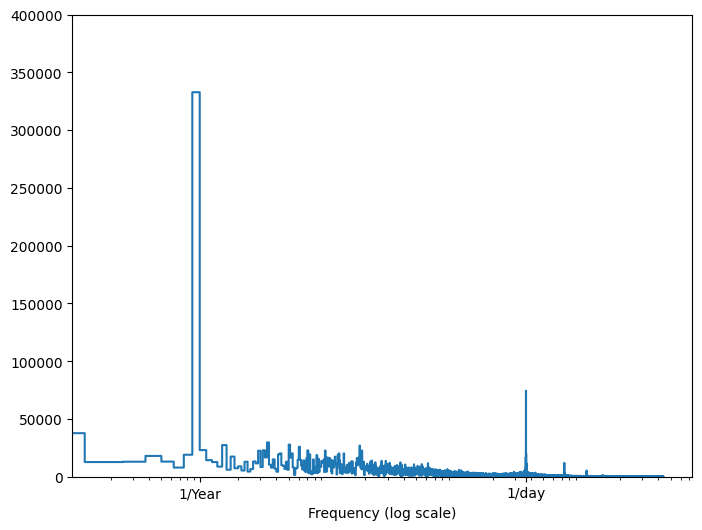

In [56]:
plt.step(no_of_freq_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

Split the data
You'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [57]:
column_indices = {name: i for i, name in enumerate(df.columns)}

In [58]:
column_indices

{'p (mbar)': 0,
 'T (degC)': 1,
 'Tpot (K)': 2,
 'Tdew (degC)': 3,
 'rh (%)': 4,
 'VPmax (mbar)': 5,
 'VPact (mbar)': 6,
 'VPdef (mbar)': 7,
 'sh (g/kg)': 8,
 'H2OC (mmol/mol)': 9,
 'rho (g/m**3)': 10,
 'Wx': 11,
 'Wy': 12,
 'max Wx': 13,
 'max Wy': 14,
 'Day sin': 15,
 'Day cos': 16,
 'Year sin': 17,
 'Year cos': 18}

In [59]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [60]:
df.shape

(70091, 19)

In [61]:
num_features = df.shape[1]

In [62]:
num_features

19

In [63]:
train_df[:10]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,9.659258e-01,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,8.660254e-01,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,7.071068e-01,0.011483,0.999934
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,5.000000e-01,0.012199,0.999926
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,2.588190e-01,0.012916,0.999917
35,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,-0.041452,0.027960,-0.414519,0.279596,1.000000,4.339955e-12,0.013633,0.999907
41,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.040387,-0.404007,2.825151,-0.559395,0.965926,-2.588190e-01,0.014349,0.999897
47,999.17,-8.10,265.12,-9.05,92.8,3.31,3.07,0.24,1.92,3.08,1311.65,-0.597609,-0.401576,-1.037515,-0.697181,0.866025,-5.000000e-01,0.015066,0.999886
53,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,-0.314796,-0.128466,-0.583298,-0.238040,0.707107,-7.071068e-01,0.015783,0.999875
59,1000.27,-7.04,266.10,-8.17,91.6,3.60,3.30,0.30,2.05,3.29,1307.76,0.557228,-1.338655,1.152886,-2.769631,0.500000,-8.660254e-01,0.016500,0.999864


Normalize the data
It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [64]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [65]:
train_df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.366111,1.366069,-0.061052,1.428434
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.707200,1.224794,-0.060029,1.428424
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,1.000100,1.000059,-0.059006,1.428412
23,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,1.224850,0.707179,-0.057983,1.428400
29,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,1.366133,0.366112,-0.056960,1.428388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294353,0.169167,0.904892,0.886564,1.571997,0.947972,0.776492,1.984916,-0.493604,1.979016,1.977352,-0.882480,-0.166720,-1.508412,-0.155728,-1.363530,-0.955374,1.042725,-0.855026,-1.154613
294359,0.266787,0.879473,0.853325,1.405624,0.621793,0.742703,1.680752,-0.283962,1.672043,1.672192,-0.822662,-0.824901,-0.641039,-0.704391,-0.475387,-0.652949,1.254471,-0.855883,-1.154062
294365,0.217374,0.740824,0.719224,1.425703,1.086900,0.559461,1.716396,-0.605690,1.709479,1.707403,-0.716211,-0.030746,0.645277,0.013960,0.600050,-0.306022,1.380734,-0.856739,-1.153511
294371,0.213759,0.710783,0.689423,1.412795,1.147303,0.521772,1.692633,-0.645127,1.687018,1.683929,-0.689842,0.014300,-0.102616,-0.095117,-0.198426,0.061765,1.412909,-0.857595,-1.152959


In [66]:
train_mean

p (mbar)            988.656343
T (degC)              9.108207
Tpot (K)            283.194958
Tdew (degC)           4.599605
rh (%)               75.906008
VPmax (mbar)         13.355098
VPact (mbar)          9.356960
VPdef (mbar)          3.998056
sh (g/kg)             5.913550
H2OC (mmol/mol)       9.466371
rho (g/m**3)       1216.994357
Wx                   -0.594182
Wy                   -0.391513
max Wx               -0.962159
max Wy               -0.709401
Day sin              -0.000054
Day cos              -0.000072
Year sin              0.052824
Year cos             -0.016243
dtype: float64

In [67]:
train_std

p (mbar)            8.297466
T (degC)            8.654950
Tpot (K)            8.724746
Tdew (degC)         6.972275
rh (%)             16.555336
VPmax (mbar)        7.694738
VPact (mbar)        4.208260
VPdef (mbar)        4.817741
sh (g/kg)           2.671252
H2OC (mmol/mol)     4.260055
rho (g/m**3)       40.957704
Wx                  2.012931
Wy                  1.561507
max Wx              3.127322
max Wy              2.619663
Day sin             0.707091
Day cos             0.707137
Year sin            0.700623
Year cos            0.711403
dtype: float64

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the -9999 wind velocity value.

In [68]:
df_std = (df - train_mean) / train_std

In [69]:
df_std

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.366111,1.366069,-0.061052,1.428434
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.707200,1.224794,-0.060029,1.428424
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,1.000100,1.000059,-0.059006,1.428412
23,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,1.224850,0.707179,-0.057983,1.428400
29,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,1.366133,0.366112,-0.056960,1.428388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,1.629854,-1.165600,-1.281981,-1.428459,-0.235937,-0.996148,-1.251577,-0.499831,-1.262910,-1.264390,1.555401,-0.129648,0.148238,-0.119794,0.175300,-1.348713,0.425346,-0.065547,1.428472
420527,1.535849,-1.214127,-1.322097,-1.640728,-0.580840,-1.019541,-1.356133,-0.443788,-1.363986,-1.365328,1.583967,-0.060615,-0.214379,-0.123420,-0.251059,-1.192686,0.759926,-0.064524,1.428464
420533,1.510540,-1.370107,-1.475683,-1.649333,-0.181573,-1.087119,-1.358509,-0.549647,-1.367729,-1.370023,1.734122,-0.033443,0.415894,-0.157093,0.487113,-0.955374,1.042725,-0.063501,1.428456
420539,1.445460,-1.386283,-1.487144,-1.685190,-0.217815,-1.094917,-1.375143,-0.545496,-1.382704,-1.384107,1.734366,0.155773,0.116774,0.133325,0.115670,-0.652949,1.254471,-0.062478,1.428447


var_name='Column': Specifies the name of the new column that will contain the original column names.
value_name='Normalized': Specifies the name of the new column that will contain the values.

In [70]:
df_std = df_std.melt(var_name='Column', value_name='Normalized')

In [71]:
df_std

,Column,Normalized
0,p (mbar),0.945308
1,p (mbar),0.959770
2,p (mbar),0.986284
3,p (mbar),1.004362
4,p (mbar),1.061006
...,...,...
1331724,Year cos,1.428472
1331725,Year cos,1.428464
1331726,Year cos,1.428456
1331727,Year cos,1.428447


C:\Users\lenovo\AppData\Local\Temp\ipykernel_3344\551342916.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


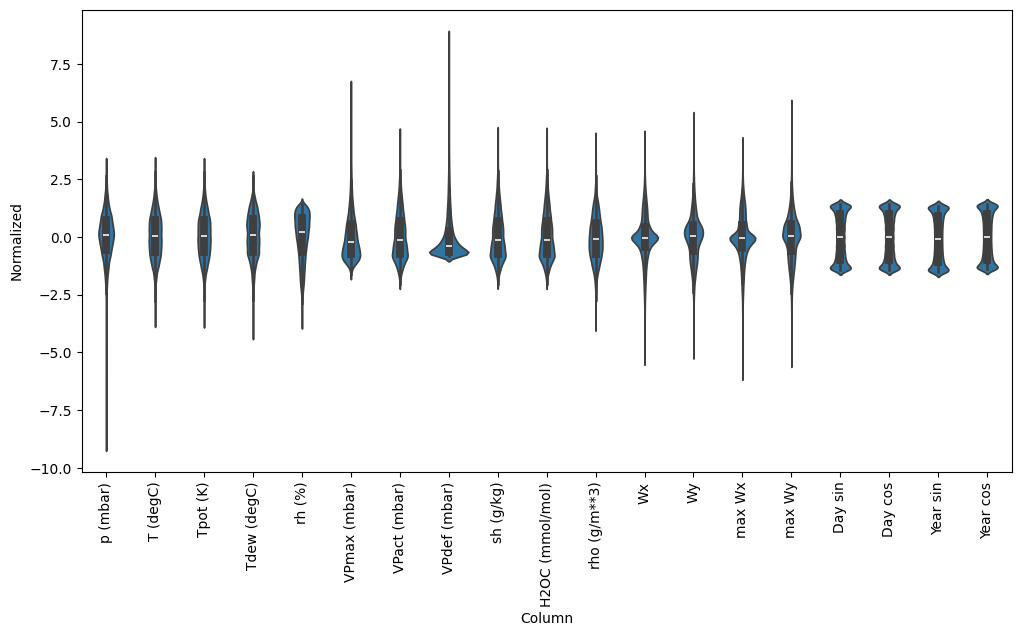

In [72]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

### Data windowing
The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

The width (number of time steps) of the input and label windows.
The time offset between them.
Which features are used as inputs, labels, or both.
This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

Single-output, and multi-output predictions.
Single-time-step and multi-time-step predictions.
This section focuses on implementing the data windowing so that it can be reused for all of those models.

Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

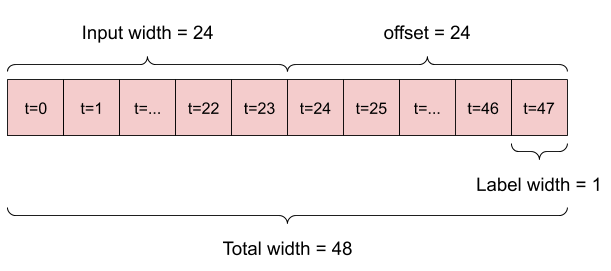

A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

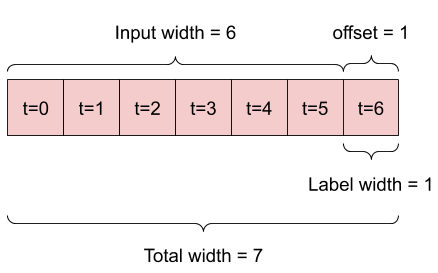

The rest of this section defines a WindowGenerator class. This class can:

Handle the indexes and offsets as shown in the diagrams above.
Split windows of features into (features, labels) pairs.
Plot the content of the resulting windows.
Efficiently generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets.

1. Indexes and offsets
Start by creating the WindowGenerator class. The __init__ method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to tf.data.Datasets of windows later

In [73]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift
    self.total_indices = np.arange(self.total_window_size)

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'total indices: {self.total_indices}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [74]:
# input_width: Number of time steps for input data.
# label_width: Number of time steps for label data.
# shift: Number of time steps to shift the window.
# train_df, val_df, test_df: Training, validation, and testing DataFrames.
# label_columns: List of column names for label data.
# Attributes
# train_df, val_df, test_df: Stored DataFrames.
# label_columns: List of label column names.
# label_columns_indices: Dictionary mapping label column names to indices.
# column_indices: Dictionary mapping column names to indices.
# input_width, label_width, shift: Window parameters.
# total_window_size: Total size of the window (input_width + shift).
# input_slice, input_indices: Slice and indices for input data.
# label_start, labels_slice, label_indices: Slice and indices for label data.

In [75]:
# Create sample DataFrames
# train_df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
# val_df = pd.DataFrame({'A': [7, 8, 9], 'B': [10, 11, 12]})
# test_df = pd.DataFrame({'A': [13, 14, 15], 'B': [16, 17, 18]})

# Create WindowGenerator instance
# wg = WindowGenerator(input_width=5, label_width=2, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None)
# input from start foroward and label  from last backward
# print(wg)

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [76]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
total indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [77]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
total indices: [0 1 2 3 4 5 6]
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

2. Split
Given a list of consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.

The example w2 you define earlier will be split like this:

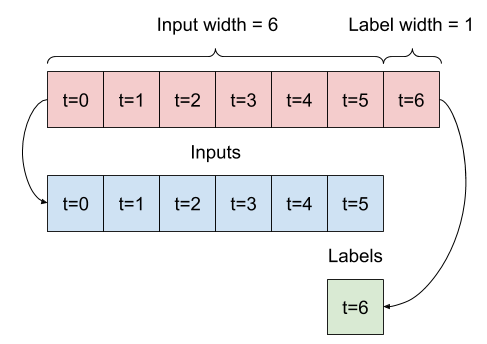

This diagram doesn't show the features axis of the data, but this split_window function also handles the label_columns so it can be used for both the single output and multi-output examples.

Shape: (batch_size, sequence_length, feature_dim) (common in sequential models).
Indexing Syntax:

: (colon): Selects all elements along that dimension.
self.input_slice: Refers to a specific slice of the second dimension (likely a range or specific indices).

In [78]:
# import numpy as np

# # Dummy data (batch_size=2, sequence_length=10, feature_dim=3)
# features = np.random.rand(2, 10, 3)

# # Define a slice
# class Model:
#     def __init__(self):
#         self.input_slice = slice(2, 5)  # Select indices 2, 3, 4

# model = Model()

# # Apply slicing
# inputs = features[:, model.input_slice, :]
# print(inputs.shape)  # (2, 3, 3)


In [79]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [80]:
# import tensorflow as tf

# # Dummy data (batch_size=2, sequence_length=3, num_features=4) # batch , row, column
# labels = tf.constant([
#     [[10, 20, 30, 40], [11, 21, 31, 41], [12, 22, 32, 42]],
#     [[50, 60, 70, 80], [51, 61, 71, 81], [52, 62, 72, 82]],
# ], dtype=tf.float32)

# # Example column indices
# column_indices = {"temperature": 0, "humidity": 1, "pressure": 2, "wind": 3}

# # Select specific columns
# label_columns = ["temperature", "humidity"]

# labels_f = labels[:,0:3, :]

# # Stack the selected columns
# stacked_labels = tf.stack(
#     [labels[:, :, column_indices[name]] for name in label_columns],
#     axis=-1
# )

# print(stacked_labels.shape)  # (2, 3, 2) # batch , row, column
# print(stacked_labels.numpy())
# print(labels_f.shape)
# print(labels_f.numpy())


In [81]:
w2.total_window_size

7

In [82]:
train_df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.366111,1.366069,-0.061052,1.428434
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.707200,1.224794,-0.060029,1.428424
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,1.000100,1.000059,-0.059006,1.428412
23,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,1.224850,0.707179,-0.057983,1.428400
29,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,1.366133,0.366112,-0.056960,1.428388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294353,0.169167,0.904892,0.886564,1.571997,0.947972,0.776492,1.984916,-0.493604,1.979016,1.977352,-0.882480,-0.166720,-1.508412,-0.155728,-1.363530,-0.955374,1.042725,-0.855026,-1.154613
294359,0.266787,0.879473,0.853325,1.405624,0.621793,0.742703,1.680752,-0.283962,1.672043,1.672192,-0.822662,-0.824901,-0.641039,-0.704391,-0.475387,-0.652949,1.254471,-0.855883,-1.154062
294365,0.217374,0.740824,0.719224,1.425703,1.086900,0.559461,1.716396,-0.605690,1.709479,1.707403,-0.716211,-0.030746,0.645277,0.013960,0.600050,-0.306022,1.380734,-0.856739,-1.153511
294371,0.213759,0.710783,0.689423,1.412795,1.147303,0.521772,1.692633,-0.645127,1.687018,1.683929,-0.689842,0.014300,-0.102616,-0.095117,-0.198426,0.061765,1.412909,-0.857595,-1.152959


In [83]:
train_df[:w2.total_window_size]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.366111,1.366069,-0.061052,1.428434
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.707200,1.224794,-0.060029,1.428424
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,1.000100,1.000059,-0.059006,1.428412
23,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,1.224850,0.707179,-0.057983,1.428400
29,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,1.366133,0.366112,-0.056960,1.428388
35,1.091135,-2.169649,-2.239029,-2.182875,1.014416,-1.354835,-1.579503,-0.786272,-1.581113,-1.583635,2.459016,0.274590,0.268633,0.175115,0.377528,1.414323,0.000102,-0.055937,1.428374
41,1.165857,-2.111879,-2.186305,-2.108294,1.026496,-1.340539,-1.550988,-0.784197,-1.554908,-1.557814,2.416777,1.308822,-0.008002,1.211039,0.057261,1.366133,-0.365907,-0.054914,1.428360


In [84]:
np.array(train_df[:w2.total_window_size])

array([[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
        -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
        -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
        -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
         2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
         3.66110559e-01,  1.36606880e+00, -6.10523600e-02,
         1.42843408e+00],
       [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
        -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
        -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
        -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
         2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
         7.07199726e-01,  1.22479437e+00, -6.00293506e-02,
         1.42842359e+00],
       [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
        -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
        -1.52722507e+00, -7.88347960e-01, -1.52870268e+00,
        -1.53199235e+00,  2.32399847e+00,  2.07982702e-01,
    

In [85]:
np.array(train_df[100:100+w2.total_window_size])

array([[-3.71962089e-01, -1.25687689e+00, -1.22238033e+00,
        -1.15451638e+00,  7.42599923e-01, -1.03903453e+00,
        -1.09949481e+00, -6.99094503e-01, -1.09444941e+00,
        -1.09537822e+00,  1.11787619e+00, -8.10131267e-03,
        -1.85871108e+00, -1.28341853e-02, -1.79355171e+00,
         1.36613340e+00,  3.66112004e-01,  4.11245445e-02,
         1.42381315e+00],
       [-3.23754599e-01, -1.25572149e+00, -1.22581883e+00,
        -1.15881913e+00,  7.24478878e-01, -1.03773494e+00,
        -1.10187109e+00, -6.94943180e-01, -1.09819297e+00,
        -1.09772561e+00,  1.12935144e+00,  2.36194026e-01,
        -9.25164983e-01,  2.32757121e-01, -1.11198763e+00,
         1.41432266e+00,  1.02415088e-04,  4.21441644e-02,
         1.42373053e+00],
       [-2.24929242e-01, -1.29269455e+00, -1.26937310e+00,
        -1.20758371e+00,  7.18438529e-01, -1.05462960e+00,
        -1.13038644e+00, -6.97018842e-01, -1.12439791e+00,
        -1.12824165e+00,  1.19307572e+00,  9.29816378e-01,
    

In [86]:
np.array(train_df[200:200+w2.total_window_size])

array([[ 1.76724532e+00, -2.92182009e+00, -3.03217517e+00,
        -3.21983946e+00,  6.58035046e-01, -1.51208509e+00,
        -1.86940929e+00, -7.82120974e-01, -1.86562333e+00,
        -1.87236358e+00,  3.47518604e+00, -1.54728495e-01,
         5.90998243e-01, -3.81836404e-01,  7.53717192e-01,
         1.00009963e+00, -9.99854377e-01,  1.42703052e-01,
         1.41199738e+00],
       [ 1.83112024e+00, -2.81205631e+00, -2.92787414e+00,
        -3.07784850e+00,  6.82196439e-01, -1.49389084e+00,
        -1.83851766e+00, -7.80045313e-01, -1.83567483e+00,
        -1.84184754e+00,  3.36897891e+00, -6.32989779e-02,
         5.95178293e-01, -1.40998787e-01,  6.70026888e-01,
         7.07199726e-01, -1.22458954e+00,  1.43714046e-01,
         1.41184306e+00],
       [ 1.83353062e+00, -2.54169080e+00, -2.66081765e+00,
        -2.79099807e+00,  5.49308775e-01, -1.44190726e+00,
        -1.76722928e+00, -7.59288695e-01, -1.76829070e+00,
        -1.77377329e+00,  3.06818080e+00, -6.51143324e-02,
    

create batch using stack

In [87]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


In [88]:
example_window

<tf.Tensor: shape=(3, 7, 19), dtype=float64, numpy=
array([[[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
         -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
         -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
         -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
          2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
          3.66110559e-01,  1.36606880e+00, -6.10523600e-02,
          1.42843408e+00],
        [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
         -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
         -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
         -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
          2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
          7.07199726e-01,  1.22479437e+00, -6.00293506e-02,
          1.42842359e+00],
        [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
         -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
         -1.52722507e+00, -7.88347960e-01, -1.52870268

In [89]:
inputs = example_window[:, w2.input_slice, :]

In [90]:
inputs

<tf.Tensor: shape=(3, 6, 19), dtype=float64, numpy=
array([[[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
         -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
         -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
         -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
          2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
          3.66110559e-01,  1.36606880e+00, -6.10523600e-02,
          1.42843408e+00],
        [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
         -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
         -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
         -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
          2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
          7.07199726e-01,  1.22479437e+00, -6.00293506e-02,
          1.42842359e+00],
        [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
         -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
         -1.52722507e+00, -7.88347960e-01, -1.52870268

In [91]:
labels = example_window[:, w2.labels_slice, :]

In [92]:
labels

<tf.Tensor: shape=(3, 1, 19), dtype=float64, numpy=
array([[[ 1.16585687, -2.11187895, -2.18630526, -2.10829405,
          1.0264963 , -1.34053929, -1.55098787, -0.78419664,
         -1.55490762, -1.55781362,  2.41677711,  1.30882225,
         -0.00800171,  1.2110392 ,  0.05726148,  1.3661334 ,
         -0.36590717, -0.05491443,  1.42836033]],

       [[ 0.15832031, -1.46022873, -1.46536735, -1.39260223,
          0.77280166, -1.12480743, -1.23256645, -0.71985112,
         -1.22921766, -1.2338741 ,  1.46481946,  2.73699567,
          1.02038929,  2.75528419,  0.98525249,  0.36611056,
         -1.36586397,  0.04724135,  1.42330667]],

       [[ 1.62262285, -1.47871527, -1.59144552, -2.13411059,
         -0.96198639, -1.13130538, -1.56049298, -0.4437881 ,
         -1.56613831, -1.56955056,  1.88305579, -0.17285229,
         -0.04615311, -0.16000027, -0.00391417, -0.99994604,
         -0.99985438,  0.14876732,  1.41106077]]])>

In [93]:
labels_temp = tf.stack(
        [labels[:, :, w2.column_indices['T (degC)']] for name in w2.label_columns],
        axis=-1)

In [94]:
labels_temp

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-2.11187895]],

       [[-1.46022873]],

       [[-1.47871527]]])>

In [95]:
inputs.set_shape([None, w2.input_width, None])

In [96]:
inputs.shape

TensorShape([3, 6, 19])

In [97]:
labels.set_shape([None, w2.label_width, None])

In [98]:
labels.shape

TensorShape([3, 1, 19])

In [99]:
example_inputs, example_labels = w2.split_window(example_window)

In [100]:
example_inputs

<tf.Tensor: shape=(3, 6, 19), dtype=float64, numpy=
array([[[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
         -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
         -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
         -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
          2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
          3.66110559e-01,  1.36606880e+00, -6.10523600e-02,
          1.42843408e+00],
        [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
         -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
         -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
         -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
          2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
          7.07199726e-01,  1.22479437e+00, -6.00293506e-02,
          1.42842359e+00],
        [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
         -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
         -1.52722507e+00, -7.88347960e-01, -1.52870268

In [101]:
example_labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-2.11187895]],

       [[-1.46022873]],

       [[-1.47871527]]])>

In [102]:



print('All shapes are: (batch, time or row, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time or row, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the WindowGenerator was initialized with label_columns=['T (degC)']. Initially, this tutorial will build models that predict single output labels.

3. Plot
Here is a plot method that allows a simple visualization of the split window:

In [103]:
w2.example = example_inputs, example_labels

In [104]:
w2.example

(<tf.Tensor: shape=(3, 6, 19), dtype=float64, numpy=
 array([[[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
          -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
          -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
          -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
           2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
           3.66110559e-01,  1.36606880e+00, -6.10523600e-02,
           1.42843408e+00],
         [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
          -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
          -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
          -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
           2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
           7.07199726e-01,  1.22479437e+00, -6.00293506e-02,
           1.42842359e+00],
         [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
          -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
          -1.52722507e+00, -7.8834796

In [105]:
w2.example[0]

<tf.Tensor: shape=(3, 6, 19), dtype=float64, numpy=
array([[[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
         -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
         -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
         -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
          2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
          3.66110559e-01,  1.36606880e+00, -6.10523600e-02,
          1.42843408e+00],
        [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
         -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
         -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
         -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
          2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
          7.07199726e-01,  1.22479437e+00, -6.00293506e-02,
          1.42842359e+00],
        [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
         -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
         -1.52722507e+00, -7.88347960e-01, -1.52870268

In [106]:
w2.example[1]

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-2.11187895]],

       [[-1.46022873]],

       [[-1.47871527]]])>

Creates a subplot within the figure.
max_n: Total number of subplots (one per row, as 1 specifies a single column).
n+1: Specifies the position of the current subplot (subplot numbering starts at 1, not 0).

marker='.': Marks each data point with a dot on the line.
zorder=-10: Controls the drawing order. A lower zorder means this plot will appear behind other elements, like scatter points.

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]  #It determines the index of the column to be plotted (plot_col_index) using self.column_indices.
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index], #batch ,row, col
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

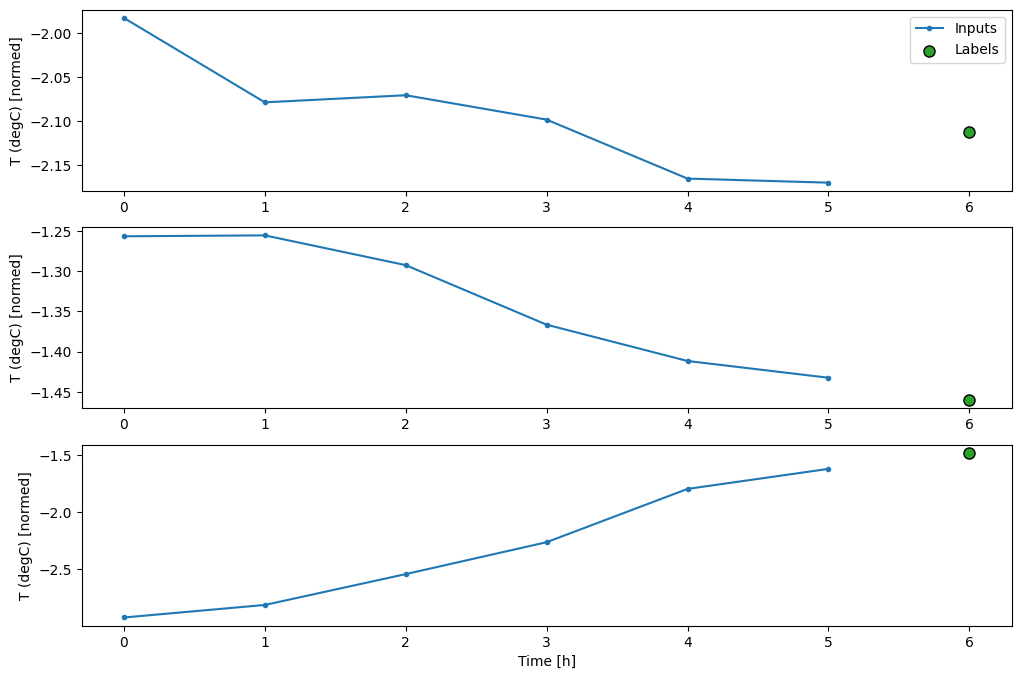

In [108]:
w2.plot()

You can plot the other columns, but the example window w2 configuration only has labels for the T (degC) column.

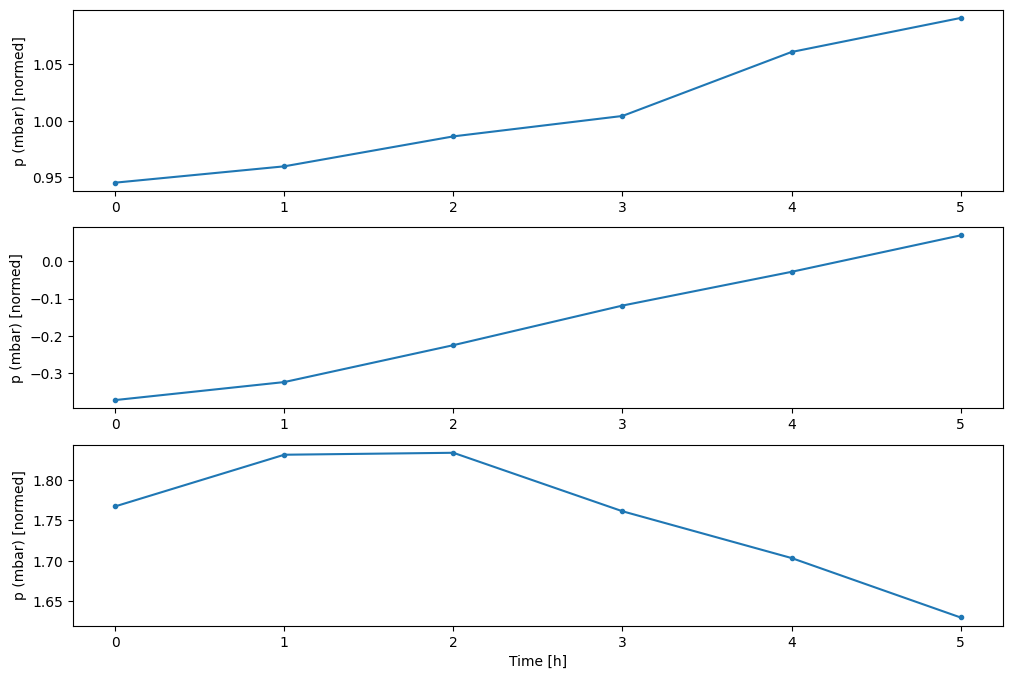

In [109]:
w2.plot(plot_col='p (mbar)')

4. Create tf.data.Datasets
Finally, this make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs using the tf.keras.utils.timeseries_dataset_from_array function

In [110]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

Add properties for accessing them as tf.data.Datasets using the make_dataset method you defined earlier. Also, add a standard example batch for easy access and plotting:




@property:

This is a Python decorator that allows a method to be accessed like an attribute.
When you use @property, you can access self.train directly without parentheses (i.e., self.train instead of self.train()).
It is commonly used to define "read-only" computed attributes.

This defines the method named train within the class.
Since it’s decorated with @property, it will be treated as a property, not a regular method.
return self.make_dataset(self.train_df):

The train property calls another method (self.make_dataset) and passes self.train_df to it.
self.make_dataset: A method of the class, likely used to prepare or transform data.
self.train_df: An attribute of the class, presumably containing the training data (e.g., a DataFrame or similar structure).

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df) # train_df positional argument

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

The docstring explains the purpose: to get and cache an example batch of inputs and labels.
result = getattr(self, '_example', None):

getattr: Checks if the object (self) already has an attribute named _example.
If _example exists, it assigns its value to result.
If _example does not exist, it assigns None to result

If _example is not already cached, the code fetches a new example batch.
result = next(iter(self.train)):

Fetches one batch of data from the train dataset:
self.train: Refers to the training dataset, likely a generator or iterable.
iter(self.train): Creates an iterator for the training dataset.
next(): Retrieves the next item (in this case, the first batch of inputs and labels).

In [112]:
# class DataHandler:
#     def __init__(self, train_df):
#         self.train_df = train_df  # Raw training data

#     def make_dataset(self, df):
#         # Example preprocessing: normalize and batch the data
#         return df * 0.1  # Simplified example

#     @property
#     def train(self):
#         return self.make_dataset(self.train_df)

# # Example usage:
# handler = DataHandler(train_df=[10, 20, 30])  # Train data
# print(handler.train)  # Outputs processed data: [1.0, 2.0, 3.0]


Now, the WindowGenerator object gives you access to the tf.data.Dataset objects, so you can easily iterate over the data.

The Dataset.element_spec property tells you the structure, data types, and shapes of the dataset elements.

In [114]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a Dataset yields concrete batches:

In [115]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


Single step models
The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the T (degC) value one hour into the future.

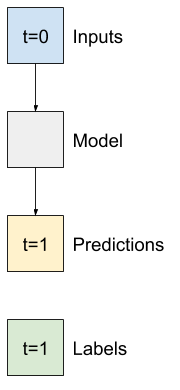

Configure a WindowGenerator object to produce these single-step (input, label) pairs:

In [116]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
total indices: [0 1]
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The window object creates tf.data.Datasets from the training, validation, and test sets, allowing you to easily iterate over batches of data.

In [117]:
for example_inputs, example_labels in single_step_window.train.take(1):  # for train train_df positinal arguments
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


Baseline
Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature.

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

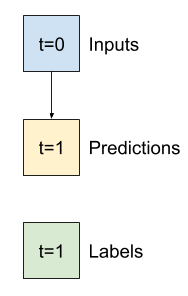

In [119]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index] #[1,2,3]
    return result[:, :, tf.newaxis] #[[1],[2],[3]]

In [ ]:
# w2.train

Instantiate and evaluate this model:

In [121]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0121 - mean_absolute_error: 0.0770


In [129]:
single_step_window.val

<_MapDataset element_spec=(TensorSpec(shape=(None, 1, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [122]:
baseline

<Baseline name=baseline, built=True>

In [123]:
baseline.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [124]:
val_performance

{'Baseline': {'loss': 0.012845639139413834,
  'mean_absolute_error': 0.07846628129482269}}

In [125]:
performance

{'Baseline': {'loss': 0.014162617735564709,
  'mean_absolute_error': 0.08516009896993637}}

That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The WindowGenerator has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider WindowGenerator that generates windows 24 hours of consecutive inputs and labels at a time. The new wide_window variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the time axis acts like the batch axis: each prediction is made independently with no interaction between time steps:

In [126]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
total indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same baseline model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

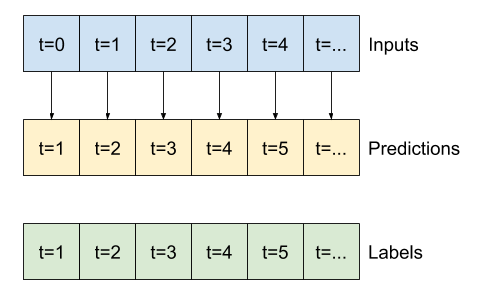

In [131]:
wide_window.example

(<tf.Tensor: shape=(32, 24, 19), dtype=float32, numpy=
 array([[[-0.6913367 , -1.2222147 , -1.1650721 , ..., -0.5410703 ,
           0.6212977 ,  1.2496711 ],
         [-0.628667  , -1.2453228 , -1.19258   , ..., -0.86077905,
           0.6221904 ,  1.249179  ],
         [-0.609384  , -1.2106606 , -1.1593412 , ..., -1.1218202 ,
           0.6230828 ,  1.2486863 ],
         ...,
         [-0.8106502 , -1.4371206 , -1.3702357 , ...,  0.54127514,
           0.6399691 ,  1.2392045 ],
         [-0.80221397, -1.4590733 , -1.3931589 , ...,  0.18468635,
           0.64085424,  1.2386992 ],
         [-0.8106502 , -1.4590733 , -1.3920128 , ..., -0.18448152,
           0.64173895,  1.2381933 ]],
 
        [[-0.03450965,  0.758155  ,  0.75704694, ...,  1.2247944 ,
          -1.0162449 , -1.0342132 ],
         [-0.09115346,  0.75468874,  0.75819314, ...,  1.3660688 ,
          -1.017014  , -1.0335488 ],
         [-0.07910158,  0.7315806 ,  0.73412365, ...,  1.4142549 ,
          -1.0177826 , -1.032

In [ ]:
wide_window.example

In [130]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

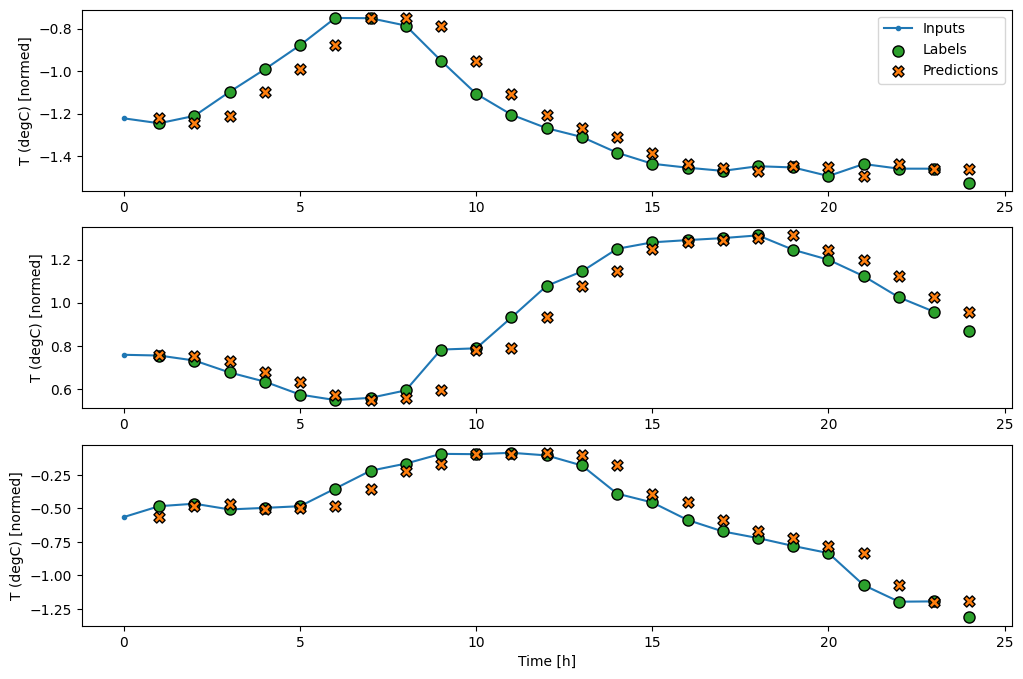

In [132]:
wide_window.plot(baseline)

In [133]:
baseline.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Linear model
The simplest trainable model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

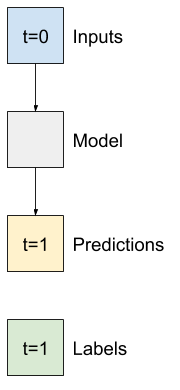

A tf.keras.layers.Dense layer with no activation set is a linear model. The layer only transforms the last axis of the data from (batch, time, inputs) to (batch, time, units); it is applied independently to every item across the batch and time axes

In [134]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [135]:
linear.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [136]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [137]:
linear.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32, 1, 1)             │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20 (80.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

This tutorial trains many models, so package the training procedure into a function:

In [138]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [139]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8051 - mean_absolute_error: 0.5985 - val_loss: 0.0186 - val_mean_absolute_error: 0.1016
Epoch 2/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0161 - mean_absolute_error: 0.0949 - val_loss: 0.0102 - val_mean_absolute_error: 0.0749
Epoch 3/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0097 - mean_absolute_error: 0.0730 - val_loss: 0.0088 - val_mean_absolute_error: 0.0685
Epoch 4/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0090 - mean_absolute_error: 0.0697 - val_loss: 0.0087 - val_mean_absolute_error: 0.0677
Epoch 5/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0089 - mean_absolute_error: 0.0697 - val_loss: 0.0087 - val_mean_absolute_error: 0.0681
Epoch 6/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0089 - mean_absolute_error: 0.0696 - val_loss: 0.0086 - val_mean_absolute_error: 0.0672
Epoch 7/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0089 - mean_absolute_err

In [140]:
val_performance

{'Baseline': {'loss': 0.012845639139413834,
  'mean_absolute_error': 0.07846628129482269},
 'Linear': {'loss': 0.008805925026535988,
  'mean_absolute_error': 0.06871113181114197}}

In [141]:
performance

{'Baseline': {'loss': 0.014162617735564709,
  'mean_absolute_error': 0.08516009896993637},
 'Linear': {'loss': 0.008730966597795486,
  'mean_absolute_error': 0.06761205941438675}}

In [142]:
history

Like the baseline model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The time axis acts like another batch axis. There are no interactions between the predictions at each time step.

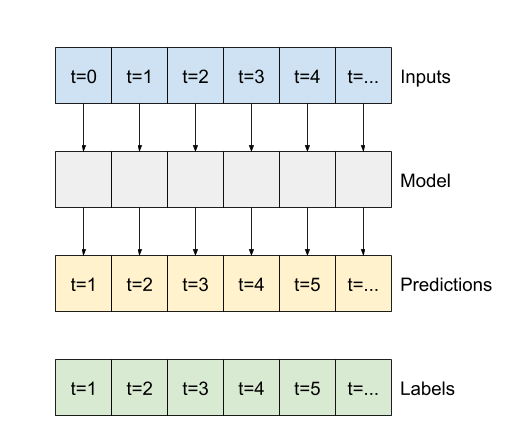

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [144]:
wide_window

Total window size: 25
total indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [145]:
wide_window.example

(<tf.Tensor: shape=(32, 24, 19), dtype=float32, numpy=
 array([[[-0.6913367 , -1.2222147 , -1.1650721 , ..., -0.5410703 ,
           0.6212977 ,  1.2496711 ],
         [-0.628667  , -1.2453228 , -1.19258   , ..., -0.86077905,
           0.6221904 ,  1.249179  ],
         [-0.609384  , -1.2106606 , -1.1593412 , ..., -1.1218202 ,
           0.6230828 ,  1.2486863 ],
         ...,
         [-0.8106502 , -1.4371206 , -1.3702357 , ...,  0.54127514,
           0.6399691 ,  1.2392045 ],
         [-0.80221397, -1.4590733 , -1.3931589 , ...,  0.18468635,
           0.64085424,  1.2386992 ],
         [-0.8106502 , -1.4590733 , -1.3920128 , ..., -0.18448152,
           0.64173895,  1.2381933 ]],
 
        [[-0.03450965,  0.758155  ,  0.75704694, ...,  1.2247944 ,
          -1.0162449 , -1.0342132 ],
         [-0.09115346,  0.75468874,  0.75819314, ...,  1.3660688 ,
          -1.017014  , -1.0335488 ],
         [-0.07910158,  0.7315806 ,  0.73412365, ...,  1.4142549 ,
          -1.0177826 , -1.032

In [146]:
wide_window.example[0]

<tf.Tensor: shape=(32, 24, 19), dtype=float32, numpy=
array([[[-0.6913367 , -1.2222147 , -1.1650721 , ..., -0.5410703 ,
          0.6212977 ,  1.2496711 ],
        [-0.628667  , -1.2453228 , -1.19258   , ..., -0.86077905,
          0.6221904 ,  1.249179  ],
        [-0.609384  , -1.2106606 , -1.1593412 , ..., -1.1218202 ,
          0.6230828 ,  1.2486863 ],
        ...,
        [-0.8106502 , -1.4371206 , -1.3702357 , ...,  0.54127514,
          0.6399691 ,  1.2392045 ],
        [-0.80221397, -1.4590733 , -1.3931589 , ...,  0.18468635,
          0.64085424,  1.2386992 ],
        [-0.8106502 , -1.4590733 , -1.3920128 , ..., -0.18448152,
          0.64173895,  1.2381933 ]],

       [[-0.03450965,  0.758155  ,  0.75704694, ...,  1.2247944 ,
         -1.0162449 , -1.0342132 ],
        [-0.09115346,  0.75468874,  0.75819314, ...,  1.3660688 ,
         -1.017014  , -1.0335488 ],
        [-0.07910158,  0.7315806 ,  0.73412365, ...,  1.4142549 ,
         -1.0177826 , -1.0328839 ],
        ...,


Here is the plot of its example predictions on the wide_window, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

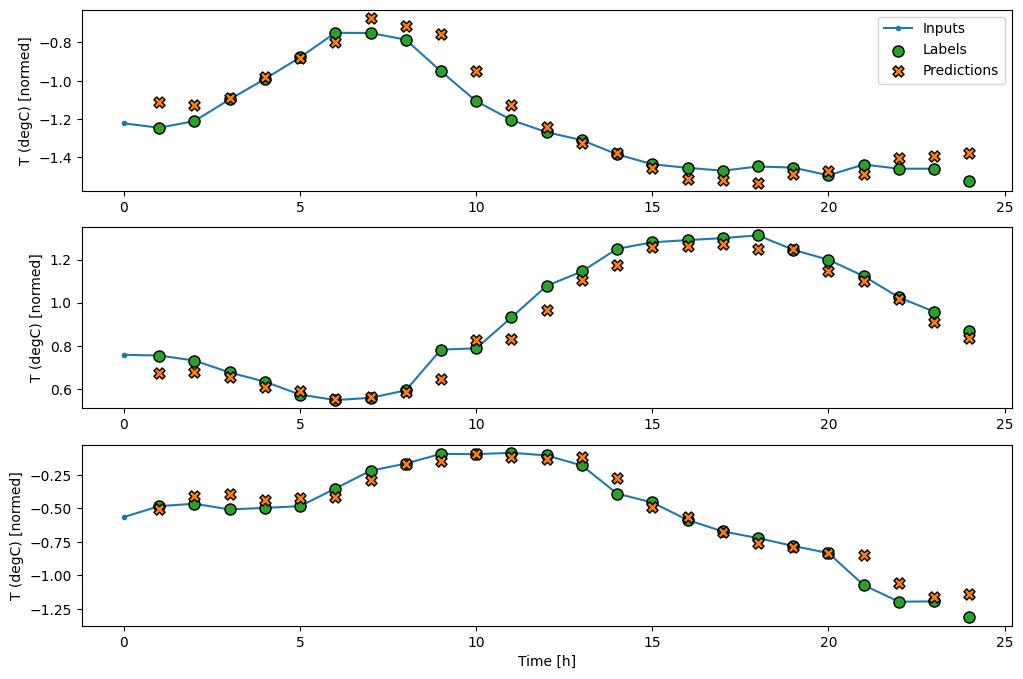

In [147]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to interpret. You can pull out the layer's weights and visualize the weight assigned to each input:

In [ ]:
# x = range(len(train_df.columns)):

# Generates a sequence of integers from 0 to the number of columns in train_df (exclusive).
# This sequence represents the x-coordinates for the bars, where each bar corresponds to a column in train_df.
# height=linear.layers[0].kernel[:, 0].numpy():

# Determines the heights of the bars.
# linear.layers[0]: Accesses the first layer of a neural network model (likely a dense layer or linear layer).
# .kernel[:, 0]: Extracts all weights (kernel values) in the first column of the weight matrix from the layer.
# Kernels are the weights learned by the layer, mapping inputs to outputs.
# .numpy(): Converts the weight values from a Tensor (if using TensorFlow) to a NumPy array, making them suitable for plotting.
# Overall:

# This creates a bar plot where:
# The x-axis corresponds to the columns of train_df.
# The y-axis represents the weights of the first output neuron for each input feature.
# Axis Object: axis = plt.gca()
# plt.gca():
# Stands for Get Current Axes.
# Returns the current axes object of the plot, which represents the plot area.

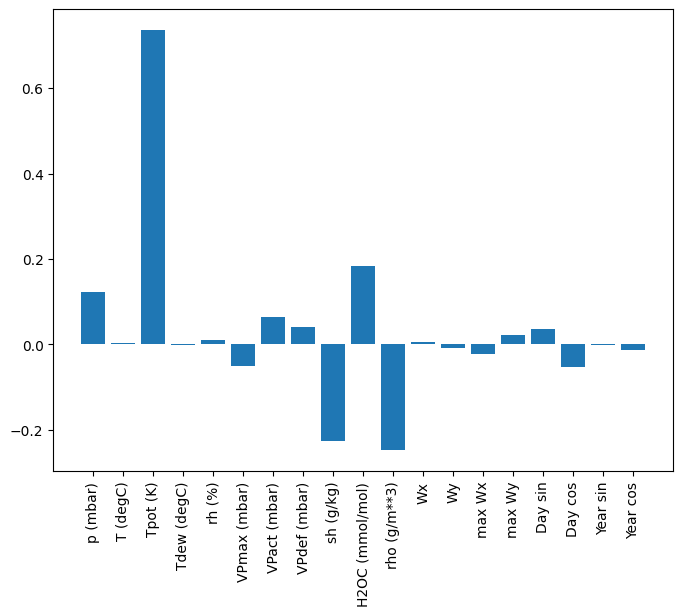

In [148]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input T (degC). This is one of the risks of random initialization

Dense
Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the linear model, except it stacks several a few Dense layers between the input and the output:

In [149]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])



In [150]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0359 - mean_absolute_error: 0.1109 - val_loss: 0.0081 - val_mean_absolute_error: 0.0662
Epoch 2/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0081 - mean_absolute_error: 0.0661 - val_loss: 0.0082 - val_mean_absolute_error: 0.0676
Epoch 3/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0076 - mean_absolute_error: 0.0636 - val_loss: 0.0074 - val_mean_absolute_error: 0.0623
Epoch 4/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0073 - mean_absolute_error: 0.0618 - val_loss: 0.0071 - val_mean_absolute_error: 0.0599
Epoch 5/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0071 - mean_absolute_error: 0.0606 - val_loss: 0.0067 - val_mean_absolute_error: 0.0573
Epoch 6/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0594 - val_loss: 0.0066 - val_mean_absolute_error: 0.0572
Epoch 7/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0068 - mean_absolute_err

In [151]:
dense.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1, 64)          │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,517 (64.52 KB)

 Trainable params: 5,505 (21.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,012 (43.02 KB)

In [152]:
val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0074 - mean_absolute_error: 0.0617


In [153]:
val_performance

{'Baseline': {'loss': 0.012845639139413834,
  'mean_absolute_error': 0.07846628129482269},
 'Linear': {'loss': 0.008805925026535988,
  'mean_absolute_error': 0.06871113181114197},
 'Dense': {'loss': 0.007025654427707195,
  'mean_absolute_error': 0.06092708185315132}}

In [154]:
performance

{'Baseline': {'loss': 0.014162617735564709,
  'mean_absolute_error': 0.08516009896993637},
 'Linear': {'loss': 0.008730966597795486,
  'mean_absolute_error': 0.06761205941438675},
 'Dense': {'loss': 0.007063332013785839,
  'mean_absolute_error': 0.062347494065761566}}

Multi-step dense
A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

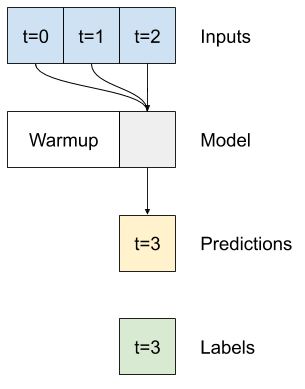

The baseline, linear and dense models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a WindowGenerator that will produce batches of three-hour inputs and one-hour labels:

Note that the Window's shift parameter is relative to the end of the two windows.

In [155]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
total indices: [0 1 2 3]
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

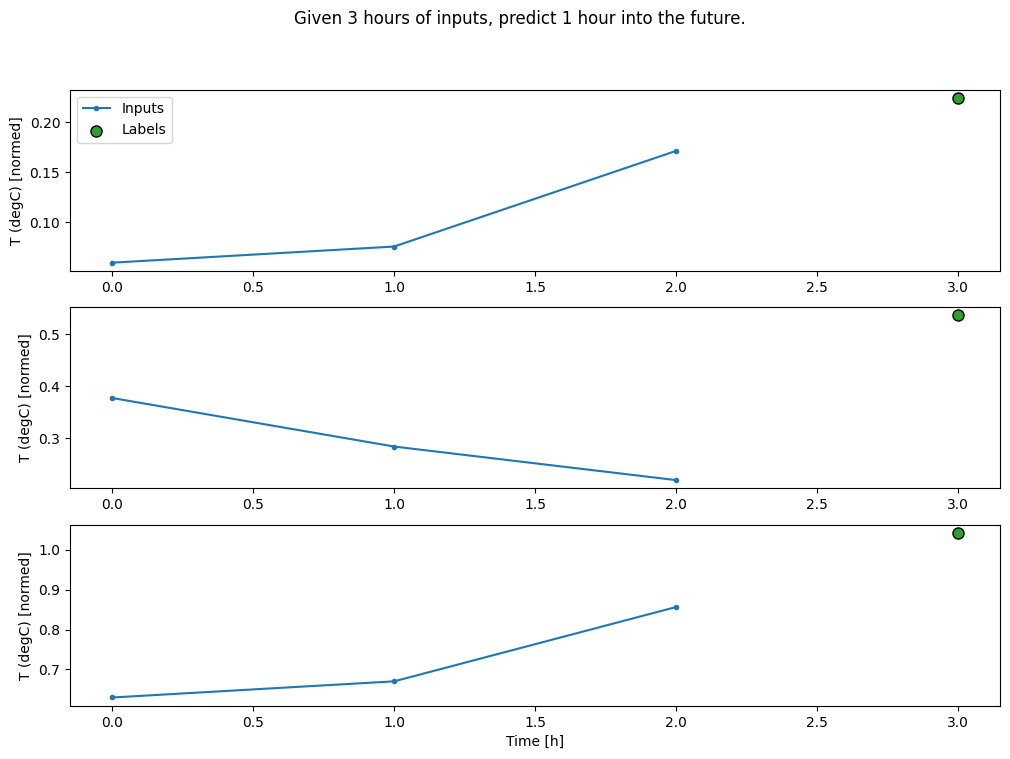

In [156]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

You could train a dense model on a multiple-input-step window by adding a tf.keras.layers.Flatten as the first layer of the model:

In [157]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [158]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [159]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0421 - mean_absolute_error: 0.1313 - val_loss: 0.0086 - val_mean_absolute_error: 0.0679
Epoch 2/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0086 - mean_absolute_error: 0.0682 - val_loss: 0.0071 - val_mean_absolute_error: 0.0601
Epoch 3/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0075 - mean_absolute_error: 0.0625 - val_loss: 0.0066 - val_mean_absolute_error: 0.0574
Epoch 4/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0071 - mean_absolute_error: 0.0606 - val_loss: 0.0068 - val_mean_absolute_error: 0.0592
Epoch 5/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0598 - val_loss: 0.0071 - val_mean_absolute_error: 0.0616


In [160]:
IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073 - mean_absolute_error: 0.0622


In [161]:
val_performance

{'Baseline': {'loss': 0.012845639139413834,
  'mean_absolute_error': 0.07846628129482269},
 'Linear': {'loss': 0.008805925026535988,
  'mean_absolute_error': 0.06871113181114197},
 'Dense': {'loss': 0.007025654427707195,
  'mean_absolute_error': 0.06092708185315132},
 'Multi step dense': {'loss': 0.00707137119024992,
  'mean_absolute_error': 0.061623163521289825}}

In [162]:
performance

{'Baseline': {'loss': 0.014162617735564709,
  'mean_absolute_error': 0.08516009896993637},
 'Linear': {'loss': 0.008730966597795486,
  'mean_absolute_error': 0.06761205941438675},
 'Dense': {'loss': 0.007063332013785839,
  'mean_absolute_error': 0.062347494065761566},
 'Multi step dense': {'loss': 0.007073413114994764,
  'mean_absolute_error': 0.061545323580503464}}

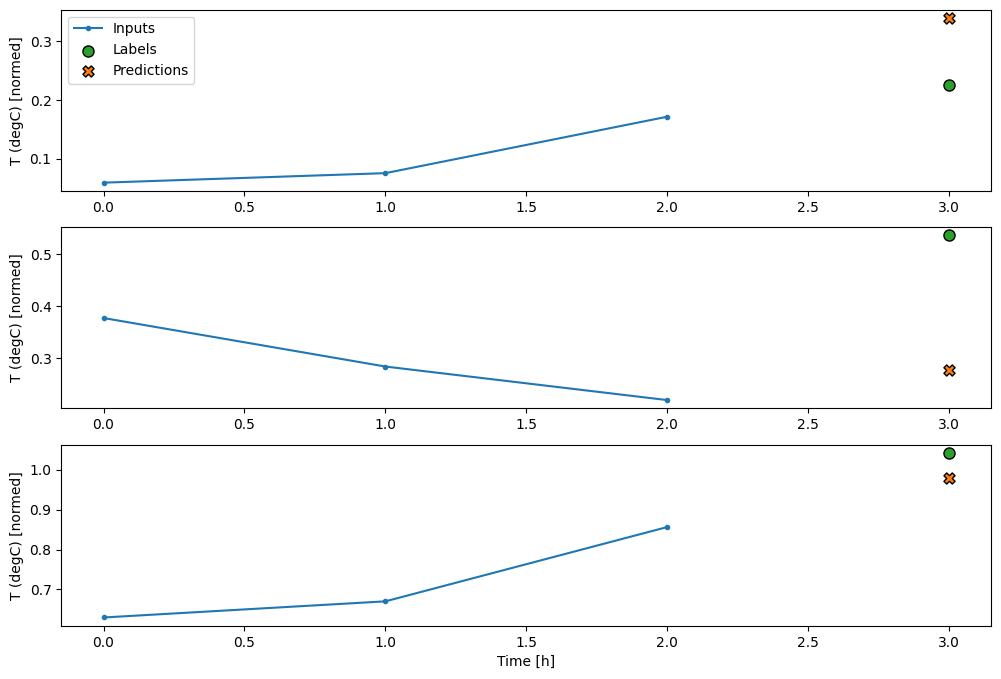

In [163]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape.

In [ ]:
# Input shape: (32, 3, 19) for multi_step_dence in convo_window

In [164]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling Sequential.call().

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


The convolutional models in the next section fix this problem.

Convolution neural network
A convolution layer (tf.keras.layers.Conv1D) also takes multiple time steps as input to each prediction.

Below is the same model as multi_step_dense, re-written with a convolution.

Note the changes:

The tf.keras.layers.Flatten and the first tf.keras.layers.Dense are replaced by a tf.keras.layers.Conv1D.
The tf.keras.layers.Reshape is no longer necessary since the convolution keeps the time axis in its output.

In [165]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to check that the model produces outputs with the expected shape:

In [166]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate it on the conv_window and it should give performance similar to the multi_step_dense model.

In [167]:
history = compile_and_fit(conv_model, conv_window)

Epoch 1/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0427 - mean_absolute_error: 0.1314 - val_loss: 0.0080 - val_mean_absolute_error: 0.0652
Epoch 2/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0083 - mean_absolute_error: 0.0666 - val_loss: 0.0069 - val_mean_absolute_error: 0.0582
Epoch 3/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0074 - mean_absolute_error: 0.0621 - val_loss: 0.0065 - val_mean_absolute_error: 0.0570
Epoch 4/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0073 - mean_absolute_error: 0.0612 - val_loss: 0.0068 - val_mean_absolute_error: 0.0591
Epoch 5/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0591 - val_loss: 0.0068 - val_mean_absolute_error: 0.0577


In [168]:
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068 - mean_absolute_error: 0.0578


In [169]:
val_performance

{'Baseline': {'loss': 0.012845639139413834,
  'mean_absolute_error': 0.07846628129482269},
 'Linear': {'loss': 0.008805925026535988,
  'mean_absolute_error': 0.06871113181114197},
 'Dense': {'loss': 0.007025654427707195,
  'mean_absolute_error': 0.06092708185315132},
 'Multi step dense': {'loss': 0.00707137119024992,
  'mean_absolute_error': 0.061623163521289825},
 'Conv': {'loss': 0.006834805011749268,
  'mean_absolute_error': 0.05770411342382431}}

In [170]:
performance

{'Baseline': {'loss': 0.014162617735564709,
  'mean_absolute_error': 0.08516009896993637},
 'Linear': {'loss': 0.008730966597795486,
  'mean_absolute_error': 0.06761205941438675},
 'Dense': {'loss': 0.007063332013785839,
  'mean_absolute_error': 0.062347494065761566},
 'Multi step dense': {'loss': 0.007073413114994764,
  'mean_absolute_error': 0.061545323580503464},
 'Conv': {'loss': 0.007079877890646458,
  'mean_absolute_error': 0.0599709190428257}}

The difference between this conv_model and the multi_step_dense model is that the conv_model can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs

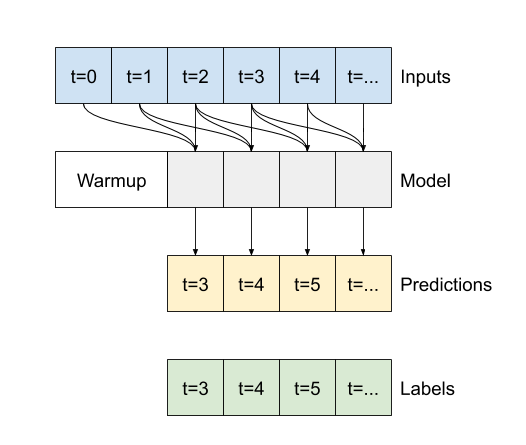

If you run it on wider input, it produces wider output:

In [171]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a WindowGenerator to produce wide windows with a few extra input time steps so the label and prediction lengths match:

In [172]:
CONV_WIDTH

3

In [173]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
total indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [174]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


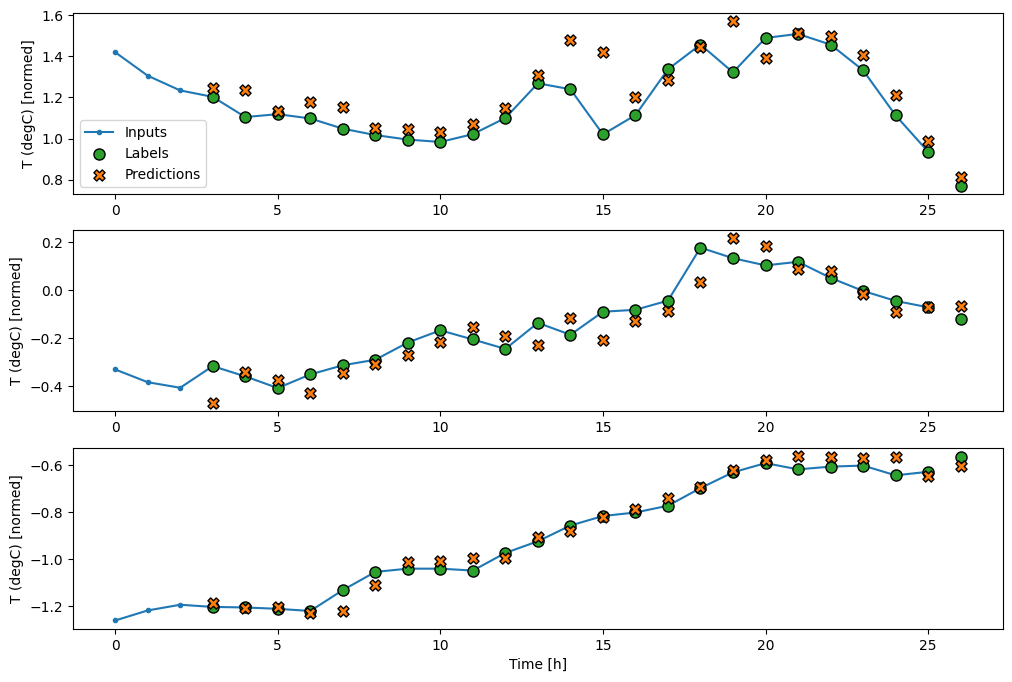

In [175]:
wide_conv_window.plot(conv_model)

Recurrent neural network
A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the Text generation with an RNN tutorial and the Recurrent Neural Networks (RNN) with Keras guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (tf.keras.layers.LSTM).

An important constructor argument for all Keras RNN layers, such as tf.keras.layers.LSTM, is the return_sequences argument. This setting can configure the layer in one of two ways:

If False, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction:


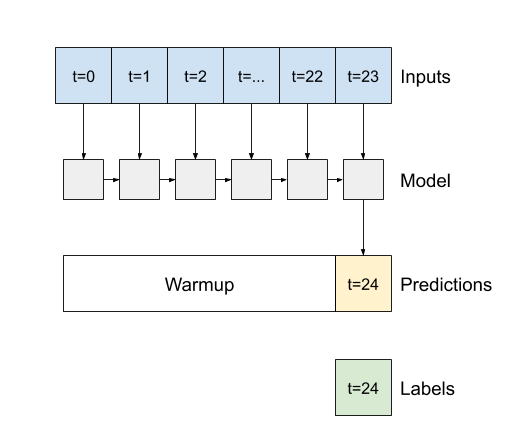

If True, the layer returns an output for each input. This is useful for:
Stacking RNN layers.
Training a model on multiple time steps simultaneously.

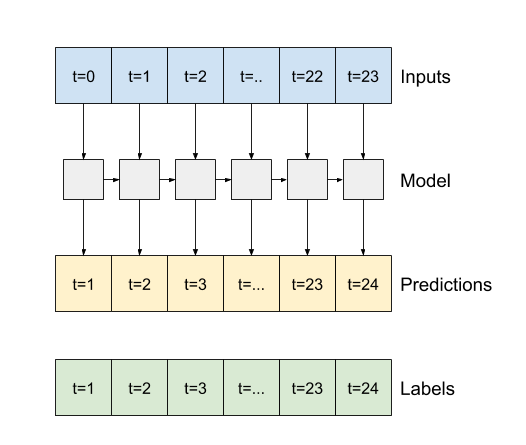

In [176]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With return_sequences=True, the model can be trained on 24 hours of data at a time

In [177]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [178]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0056 - mean_absolute_error: 0.0517


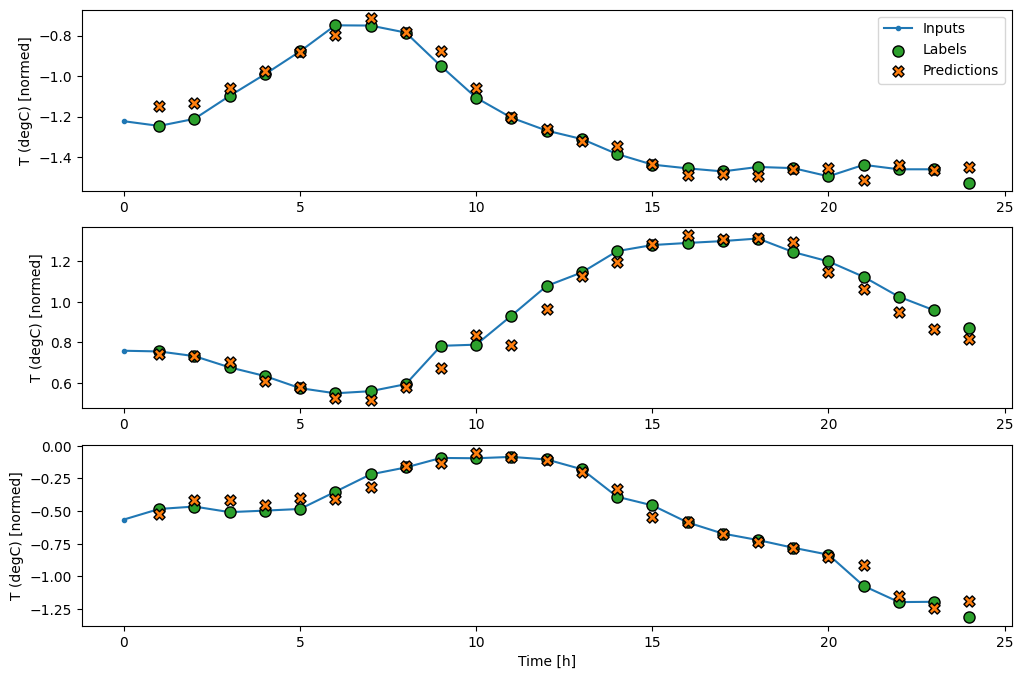

In [179]:
wide_window.plot(lstm_model)

rformance
With this dataset typically each of the models does slightly better than the one before it:

In [180]:
cm = lstm_model.metrics[1]
cm.metrics

[<MeanAbsoluteError name=mean_absolute_error>]

In [181]:
val_performance

{'Baseline': {'loss': 0.012845639139413834,
  'mean_absolute_error': 0.07846628129482269},
 'Linear': {'loss': 0.008805925026535988,
  'mean_absolute_error': 0.06871113181114197},
 'Dense': {'loss': 0.007025654427707195,
  'mean_absolute_error': 0.06092708185315132},
 'Multi step dense': {'loss': 0.00707137119024992,
  'mean_absolute_error': 0.061623163521289825},
 'Conv': {'loss': 0.006834805011749268,
  'mean_absolute_error': 0.05770411342382431},
 'LSTM': {'loss': 0.005627655889838934,
  'mean_absolute_error': 0.05188355967402458}}

In [183]:
performance

{'Baseline': {'loss': 0.014162617735564709,
  'mean_absolute_error': 0.08516009896993637},
 'Linear': {'loss': 0.008730966597795486,
  'mean_absolute_error': 0.06761205941438675},
 'Dense': {'loss': 0.007063332013785839,
  'mean_absolute_error': 0.062347494065761566},
 'Multi step dense': {'loss': 0.007073413114994764,
  'mean_absolute_error': 0.061545323580503464},
 'Conv': {'loss': 0.007079877890646458,
  'mean_absolute_error': 0.0599709190428257},
 'LSTM': {'loss': 0.005564561579376459,
  'mean_absolute_error': 0.052583225071430206}}

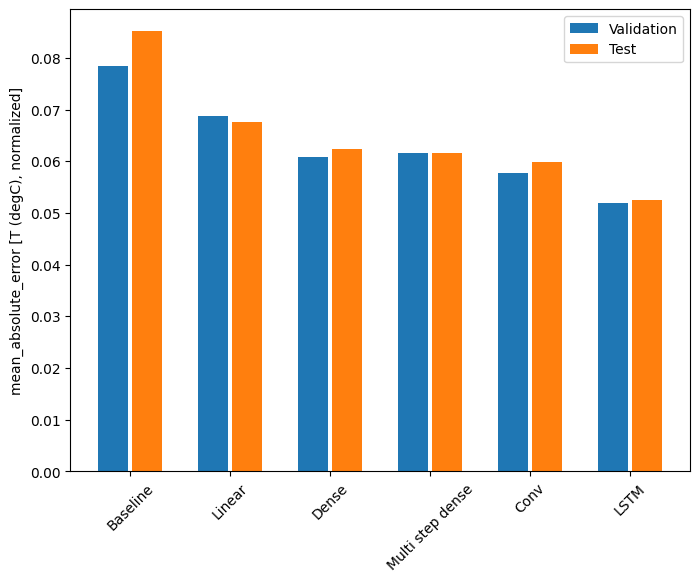

In [182]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [184]:
for name, value in performance.items():
  print(f'{name:12s}: {value[metric_name]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0676
Dense       : 0.0623
Multi step dense: 0.0615
Conv        : 0.0600
LSTM        : 0.0526


Multi-output models
The models so far all predicted a single output feature, T (degC), for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the labels (example_labels):

In [185]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


In [186]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [187]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0889 - mean_absolute_error: 0.1592


In [188]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [189]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0692 - mean_absolute_error: 0.1343


In [190]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0, return_dict=True)

print()

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0620 - mean_absolute_error: 0.1210

CPU times: total: 6min 46s
Wall time: 2min 38s


Advanced: Residual connections
The Baseline model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step. Similarly, residual networks—or ResNets—in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

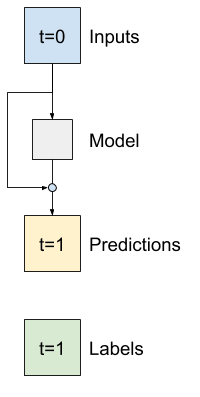

Essentially, this initializes the model to match the Baseline. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial.

Here, it is being applied to the LSTM model, note the use of the tf.initializers.zeros to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the zeros are only used on the last layer.

In [191]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [192]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0621 - mean_absolute_error: 0.1177

CPU times: total: 4min 58s
Wall time: 1min 55s


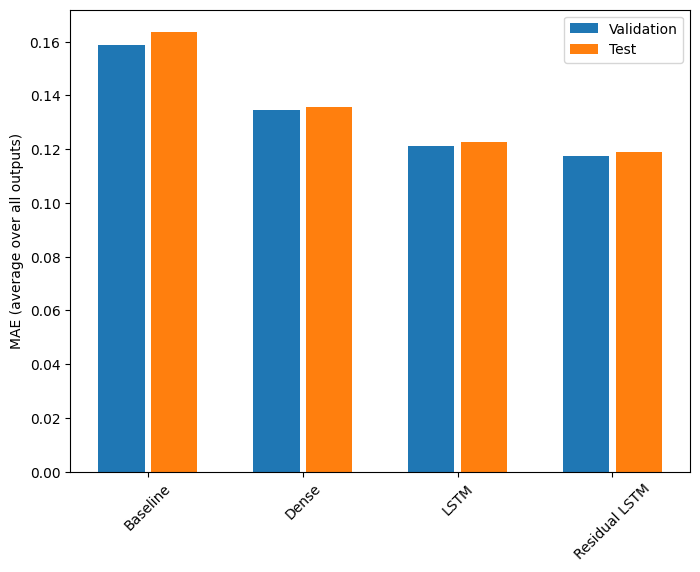

In [193]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [194]:
for name, value in performance.items():
  print(f'{name:15s}: {value[metric_name]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1358
LSTM           : 0.1226
Residual LSTM  : 0.1189


Multi-step models



Both the single-output and multiple-output models in the previous sections made single time step predictions, one hour into the future.

This section looks at how to expand these models to make multiple time step predictions.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

Single shot predictions where the entire time series is predicted at once.
Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.
In this section all the models will predict all the features across all output time steps.

For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a Window object that generates these slices from the dataset:

Total window size: 48
total indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

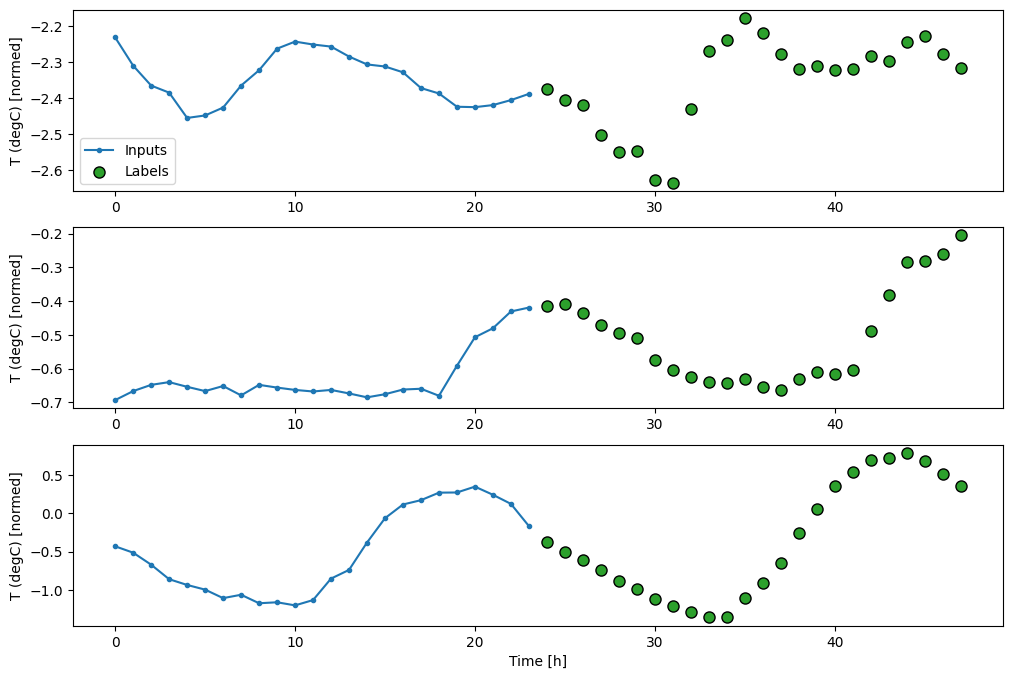

In [195]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

Baselines
A simple baseline for this task is to repeat the last input time step for the required number of output time steps:



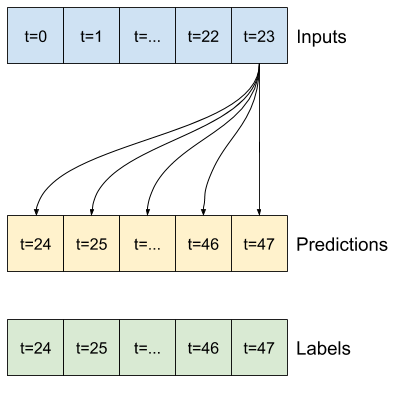

inputs: A tensor, likely of shape [batch_size, time_steps, features].
inputs[:, -1:, :]: This slices the tensor to take the last time step (-1) across the second dimension (time_steps).
: means all batches.
-1: selects only the last time step but keeps the dimension (hence the -1: instead of -1).
: at the end selects all features.
The resulting shape will be [batch_size, 1, features].
tf.tile Function:
tf.tile: Repeats the values in the input tensor along specified dimensions.
Arguments:
inputs[:, -1:, :]: The tensor of shape [batch_size, 1, features] (the last time step).
[1, OUT_STEPS, 1]: The tiling multiplier for each

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6185 - mean_absolute_error: 0.4963


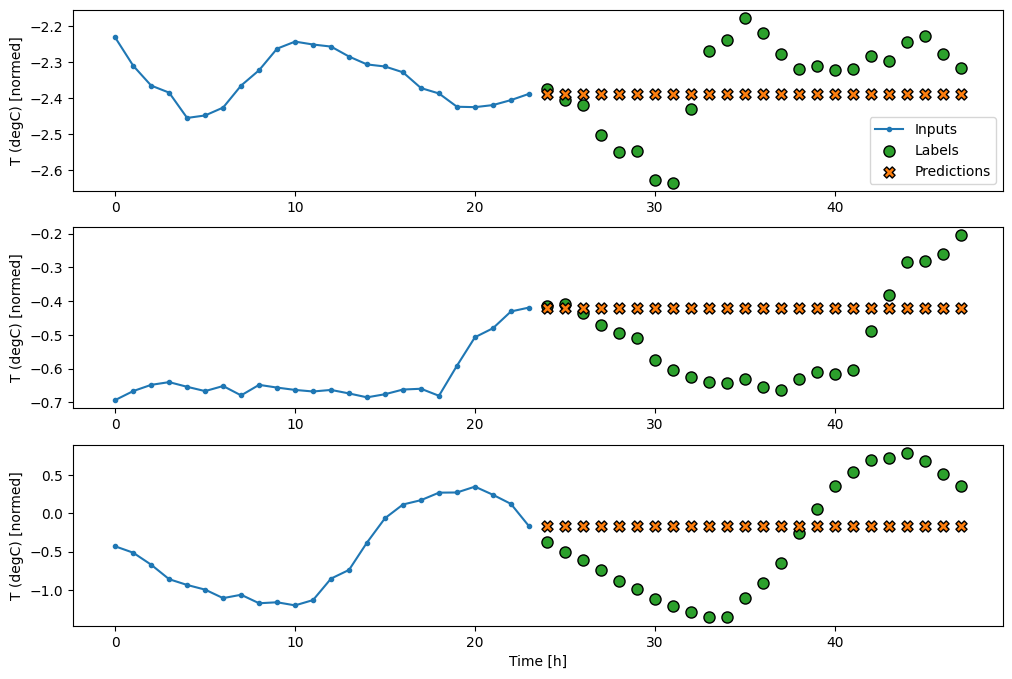

In [196]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)

Since this task is to predict 24 hours into the future, given 24 hours of the past, another simple approach is to repeat the previous day, assuming tomorrow will be similar:

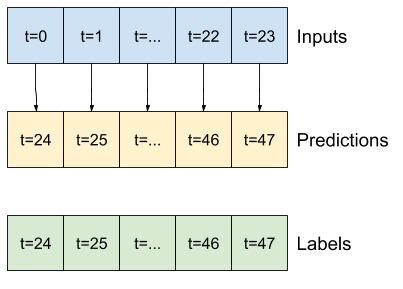

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4253 - mean_absolute_error: 0.3948


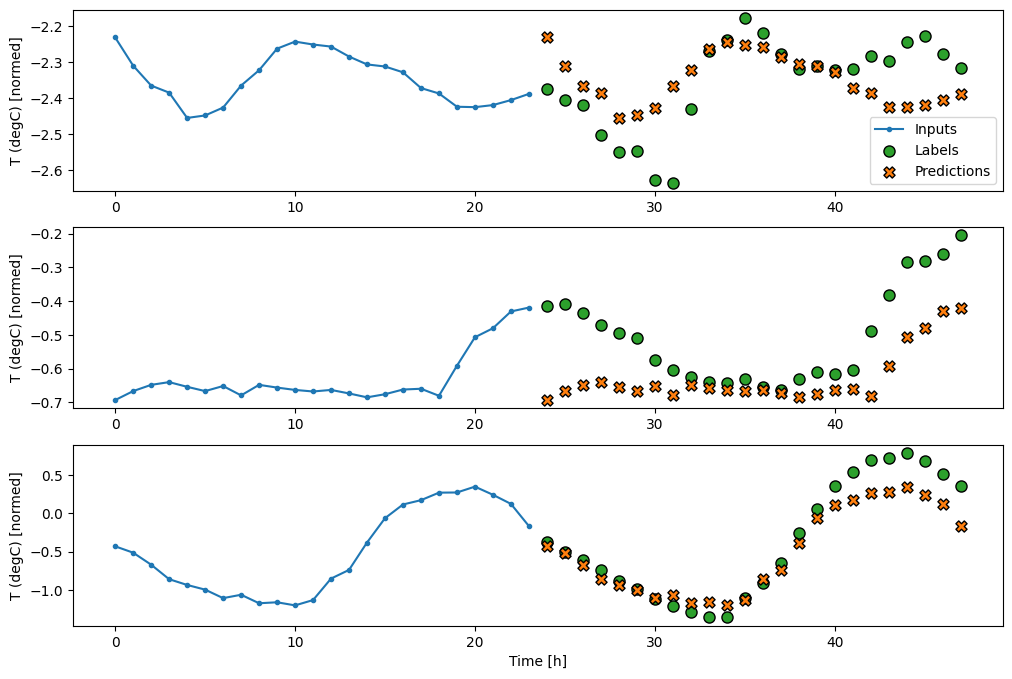

In [197]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(repeat_baseline)

Single-shot models
One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a tf.keras.layers.Dense with OUT_STEPS*features output units. The model just needs to reshape that output to the required (OUTPUT_STEPS, features).

Linear
A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict OUTPUT_STEPS time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

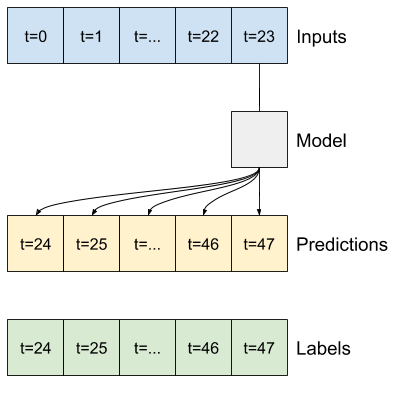

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2548 - mean_absolute_error: 0.3068


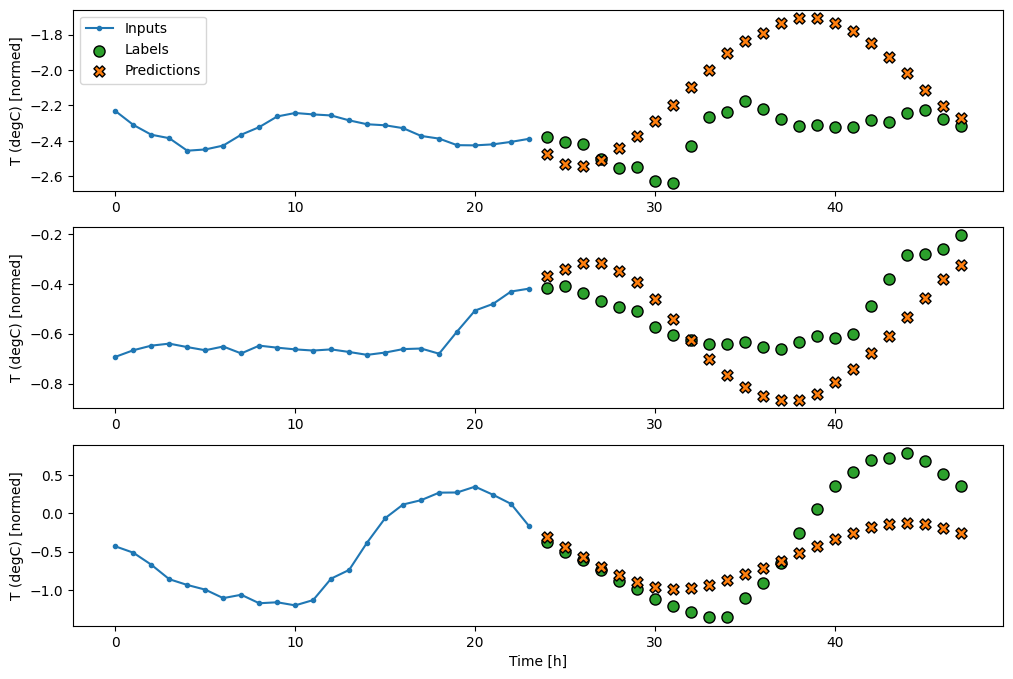

In [198]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_linear_model)

Dense
Adding a tf.keras.layers.Dense between the input and output gives the linear model more power, but is still only based on a single input time step.

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2172 - mean_absolute_error: 0.2808


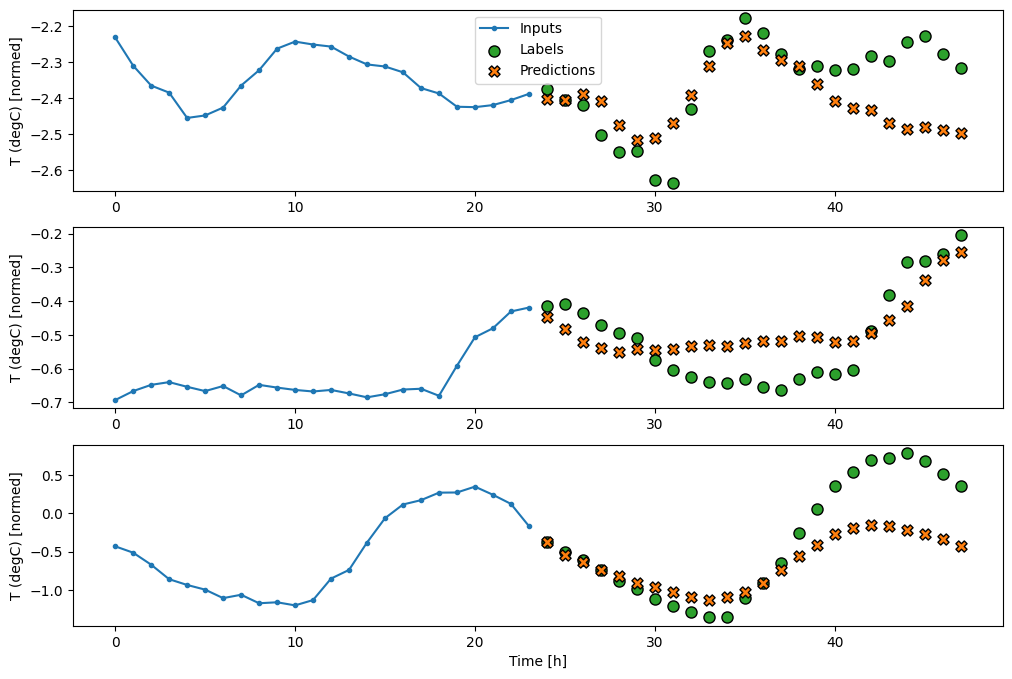

In [199]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

Dense
Adding a tf.keras.layers.Dense between the input and output gives the linear model more power, but is still only based on a single input time step

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

Dense
Adding a tf.keras.layers.Dense between the input and output gives the linear model more power, but is still only based on a single input time step

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2196 - mean_absolute_error: 0.2823


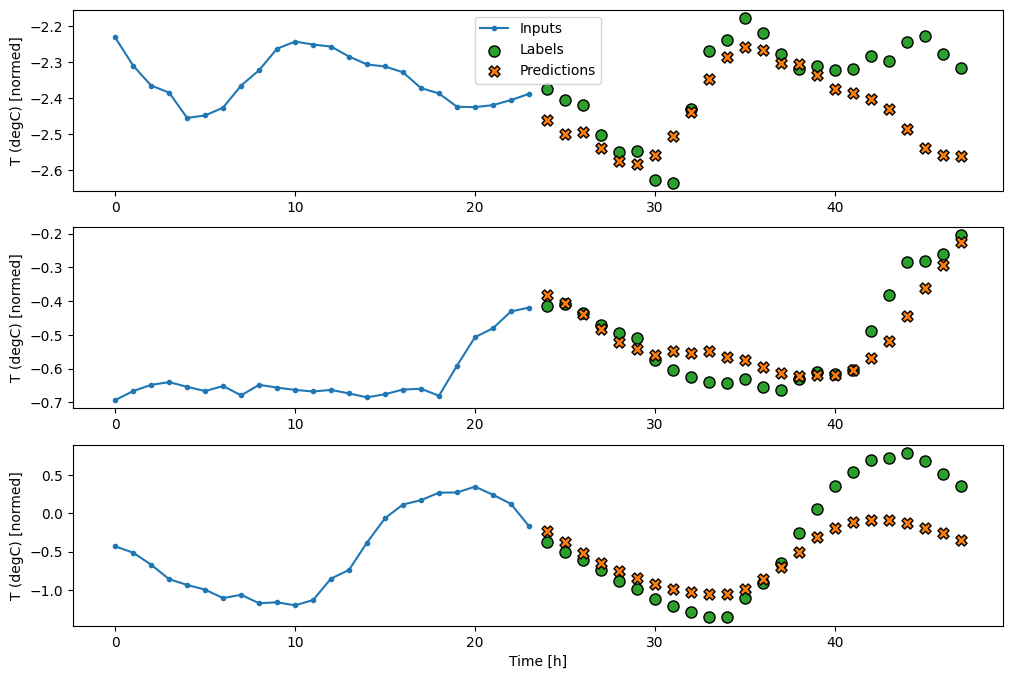

In [201]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

CNN
A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

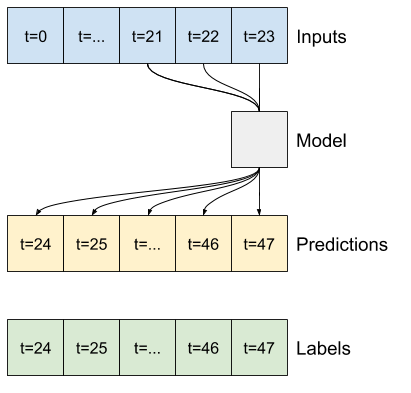

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

RNN
A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set return_sequences=False in tf.keras.layers.LSTM.

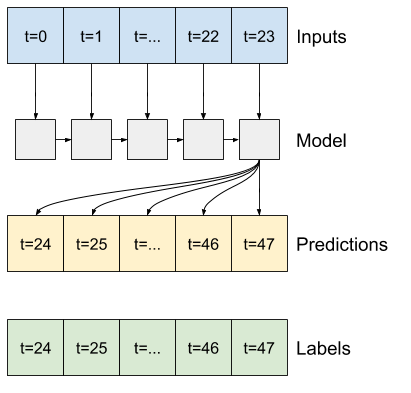

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

Advanced: Autoregressive model
The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic Generating Sequences With Recurrent Neural Networks.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

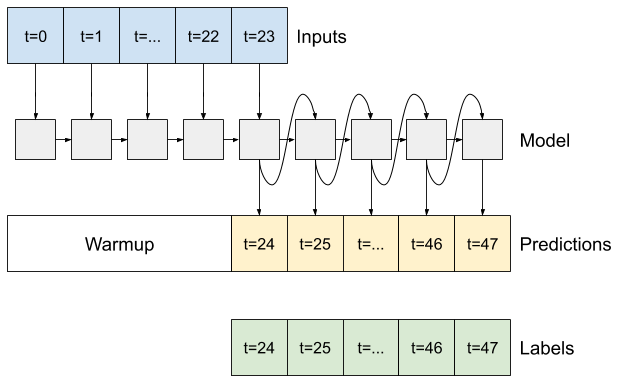

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()